# Gravitation in PHANTOM
**Test of PHANTOM long-range interaction acceleration**

<!-- @article{PriceEtAl2018,
  title = {{$<$}scp{$>$}{{Phantom}}{$<$}/Scp{$>$}: {{A Smoothed Particle Hydrodynamics}} and {{Magnetohydrodynamics Code}} for {{Astrophysics}}},
  author = {Price, Daniel J. and Wurster, James and Tricco, Terrence S. and Nixon, Chris and Toupin, Stéven and Pettitt, Alex and Chan, Conrad and Mentiplay, Daniel and Laibe, Guillaume and Glover, Simon and Dobbs, Clare and Nealon, Rebecca and Liptai, David and Worpel, Hauke and Bonnerot, Clément and Dipierro, Giovanni and Ballabio, Giulia and Ragusa, Enrico and Federrath, Christoph and Iaconi, Roberto and Reichardt, Thomas and Forgan, Duncan and Hutchison, Mark and Constantino, Thomas and Ayliffe, Ben and Hirsh, Kieran and Lodato, Giuseppe},
  date = {2018},
  journaltitle = {Publications of the Astronomical Society of Australia},
  shortjournal = {Publ. Astron. Soc. Aust.},
  volume = {35},
  number = {2018},
  eprint = {1702.03930},
  eprinttype = {arxiv},
  pages = {e031},
  issn = {1323-3580},
  doi = {10.1017/pasa.2018.25},
  url = {https://www.cambridge.org/core/product/identifier/S1323358018000255/type/journal_article},
  abstract = {We present Phantom , a fast, parallel, modular, and low-memory smoothed particle hydrodynamics and magnetohydrodynamics code developed over the last decade for astrophysical applications in three dimensions. The code has been developed with a focus on stellar, galactic, planetary, and high energy astrophysics, and has already been used widely for studies of accretion discs and turbulence, from the birth of planets to how black holes accrete. Here we describe and test the core algorithms as well as modules for magnetohydrodynamics, self-gravity, sink particles, dust–gas mixtures, H 2 chemistry, physical viscosity, external forces including numerous galactic potentials, Lense–Thirring precession, Poynting–Robertson drag, and stochastic turbulent driving. Phantom is hereby made publicly available.},
  langid = {english},
  keywords = {★, accretion, accretion disks, gravitaion, hydrodynamics, SM: general, agnetohydrodynamics (MHD), methods: numerical, PHANTOM, SPH},
  annotation = {262 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/UB8DW3WQ/Price et al - 2018 - scpPhantom-scp - A Smoothed Particle Hydrodynamics and Magnetohydrodynamics.pdf}
} -->

In [1]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];
ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",

    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]*)
<<TensorSimplify`

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 0 Kb


## Einstein Summation

In [10]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
      transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [18]:
(* different variants *)
(* Norm[dx]^2 *)
(* SquareLength[x_] := EinsteinSummation[{{i}, {i}}, {x, x}] *)
SquareLength[x_] := x.x

## Test of partice-node force in PHANTOM

### Definitions of vectors

In [22]:
(* r is a distance between particle and node *)
(* M is a mass of the node *)
$Assumptions = {
  _ \[Element] Reals,
  {r, M} \[Element] PositiveReals
};

(* rv is the relative position vector *)
rv = Array[Subscript[r, ##] &, {3}];

(* corresponding unit vector *)
(* ur = Normalize[rv] *)
ur = rv/Sqrt[SquareLength[rv]];

(* unit vector rv with hat *)
(* h means hat *)
urh = Array[Subscript[OverHat[r], ##] &, {3}];

### Quadrupole moments

In [33]:
(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
(* https://mathematica.stackexchange.com/questions/127513/how-to-create-a-symmetric-symbolic-tensor *)
Qij = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[Q, {i, j}], {3, 3}, Symmetric[{1, 2}]];
(* SymmetricMatrixQ[Qij] *)

Qi = EinsteinSummation[{{j}, {i, j}}, {ur, Qij}];
Qih = EinsteinSummation[{{j}, {i, j}}, {urh, Qij}];

In [39]:
ClearAll@DoCollapse
DoCollapse[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        SquareLength[rv] -> r*r
        , rv[[1]] -> urh[[1]]*r
        , rv[[2]] -> urh[[2]]*r
        , rv[[3]] -> urh[[3]]*r
        }
      ]
    ] // MatrixForm
  ]

ClearAll@DoExpand
DoExpand[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        Q -> urh.Qih
        , Subscript[Q, 1] -> Qih[[1]]
        , Subscript[Q, 2] -> Qih[[2]]
        , Subscript[Q, 3] -> Qih[[3]]
        (* https://mathematica.stackexchange.com/questions/192416/how-to-avoid-replace-substituting-subscripts *)
        , s_Subscript :> s
        }
      ]
    ] // MatrixForm
  ]

### Eq. 222

^
  M r
     1
-(----)
    2
   r

    ^
  M r
     2
-(----)
    2
   r

    ^
  M r
     3
-(----)
    2
   r
0
         ^
     5 Q r
          1
Q  - ------
 1     2
-----------
     4
    r

         ^
     5 Q r
          2
Q  - ------
 2     2
-----------
     4
    r

         ^
     5 Q r
          3
Q  - ------
 3     2
-----------
     4
    r
0
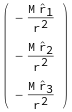
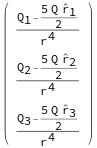

In [49]:
(* from PHANTOM eq. 222 *)
aMPhantom = -M/r^2*urh;
aQPhantom = 1/r^4*Array[(Subscript[Q, #] - 5/2*urh[[#]]*Q) &, {3}];

(* symbolic test *)
aM = -M/SquareLength[rv]*ur;
aQ = 1/SquareLength[rv]^2*(Qi - 5/2*ur*(ur.Qi));

aMPhantom // MatrixForm
FullSimplify[DoExpand[aMPhantom] - DoCollapse[aM]]

aQPhantom // MatrixForm
FullSimplify[DoExpand[aQPhantom] - DoCollapse[aQ]]

### Eq. 226

^ 2        ^  ^             ^  ^
M (-1 + 3 r  )   3 M r  r         3 M r  r
           1          1  2             1  3
--------------   ---------        ---------
       3             3                3
      r             r                r

    ^  ^                   ^ 2        ^  ^
3 M r  r         M (-1 + 3 r  )   3 M r  r
     1  2                   2          2  3
---------        --------------   ---------
    3                   3             3
   r                   r             r

    ^  ^             ^  ^                   ^ 2
3 M r  r         3 M r  r         M (-1 + 3 r  )
     1  3             2  3                   3
---------        ---------        --------------
    3                3                   3
   r                r                   r
0
                                  ^ 2                                         ^  ^
                               35 r                                      35 Q r  r
                ^         5        1                      ^         ^          1  2
Q       - 10 Q  r  + Q (-(-) + ------)     Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 1}       1  1        2      2          {1, 2}      2  1      1  2       2
--------------------------------------     ----------------------------------------
                   5                                           5
                  r                                           r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          1  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {1, 3}      3  1      1  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                      ^ 2
                              35 Q r  r                                   35 r
               ^         ^          1  2                   ^         5        2
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 10 Q  r  + Q (-(-) + ------)
 {1, 2}      2  1      1  2       2         {2, 2}       2  2        2      2
----------------------------------------   --------------------------------------
                    5                                         5
                   r                                         r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          2  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {2, 3}      3  2      2  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                       ^  ^
                              35 Q r  r                                  35 Q r  r
               ^         ^          1  3                  ^         ^          2  3
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 3}      3  1      1  3       2         {2, 3}      3  2      2  3       2
----------------------------------------   ----------------------------------------
                    5                                          5
                   r                                          r
 
                                          ^ 2
                                       35 r
                        ^         5        3
        Q       - 10 Q  r  + Q (-(-) + ------)
         {3, 3}       3  3        2      2
        --------------------------------------
                           5
>                         r
0
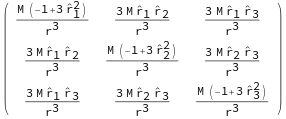
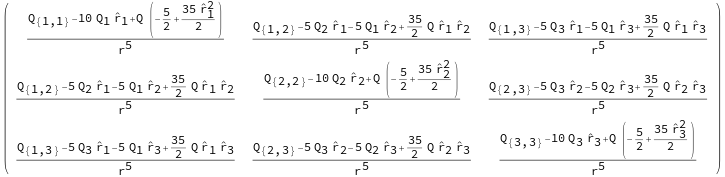

In [59]:
(* from PHANTOM eq. 226 *)
daMPhantom = M/r^3*Array[3*urh[[#]]*urh[[#2]] - KroneckerDelta[#, #2] &, {3, 3}];
daQPhantom = 1/r^5*Array[
  Qij[[#, #2]]
  + (35/2*urh[[#]]*urh[[#2]] - 5/2*KroneckerDelta[#, #2])*Q
  - 5*urh[[#]]*Subscript[Q, #2] - 5*urh[[#2]]*Subscript[Q, #]
  &, {3, 3}];

(* symbolic test *)
daM = D[aM, {rv}];
daQ = D[aQ, {rv}];

daMPhantom // MatrixForm
FullSimplify[DoCollapse[daM] - DoExpand[daMPhantom]]

daQPhantom // MatrixForm
FullSimplify[DoCollapse[daQ] - DoExpand[daQPhantom]]

### Eq. 227

^      ^ 3            ^      ^ 2 ^            ^      ^ 2 ^
-3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r   r )
          1      1              2      1   2            3      1   3
--------------------    ---------------------   ---------------------
          4                       4                       4
         r                       r                       r
       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r

       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^  ^ 2             ^      ^ 3            ^      ^ 2 ^
-3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )
        1      1  2               2      2              3      2   3
---------------------   --------------------    ---------------------
          4                       4                       4
         r                       r                       r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r

       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r
       ^      ^  ^ 2           ^      ^  ^ 2             ^      ^ 3
-3 M (-r  + 5 r  r  )   -3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )
        1      1  3             2      2  3               3      3
---------------------   ---------------------   --------------------
          4                       4                       4
         r                       r                       r
0
                                                                                   ^
                                                                              35 Q r
                                                                                    2
                                                                     (-5 Q  + ------- - 
                                                                          2      2
                                                                      
            
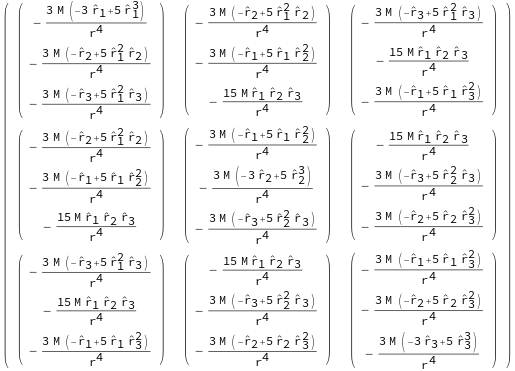
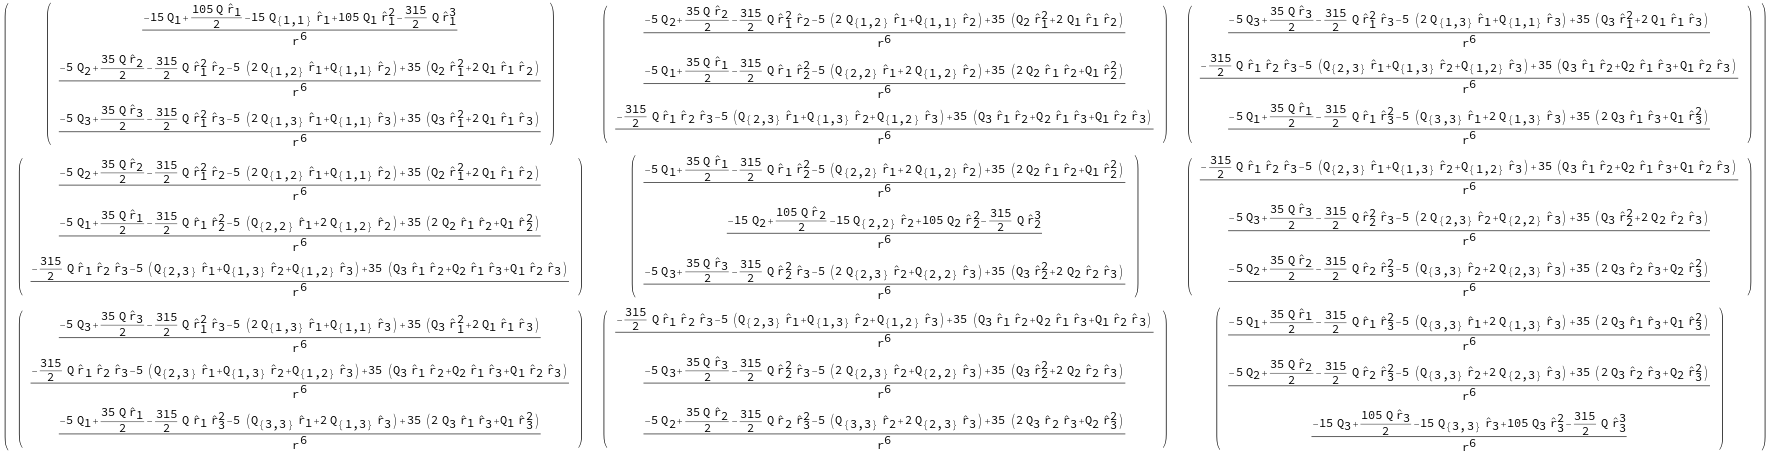

In [69]:
(* from PHANTOM eq. 227 *)
d2aMPhantom = -3*M/r^4*Array[
  5*urh[[#]]*urh[[#2]]*urh[[#3]]
  - KroneckerDelta[#2, #3]*urh[[#]]
  - KroneckerDelta[#, #3]*urh[[#2]]
  - KroneckerDelta[#, #2]*urh[[#3]]
  &, {3, 3, 3}
  ];
d2aQPhantom = 1/r^6*Array[
  - 5*(urh[[#3]]*Qij[[#, #2]] + urh[[#]]*Qij[[#2, #3]] + urh[[#2]]*Qij[[#, #3]])
  - 315/2*urh[[#]]*urh[[#2]]*urh[[#3]]*Q
  + 35/2*(KroneckerDelta[#, #2]*urh[[#3]] + KroneckerDelta[#, #3]*urh[[#2]] + KroneckerDelta[#2, #3]*urh[[#]])*Q
  + 35*(urh[[#2]]*urh[[#3]]*Subscript[Q, #] + urh[[#]]*urh[[#3]]*Subscript[Q, #2] + urh[[#]]*urh[[#2]]*Subscript[Q, #3])
  - 5*(KroneckerDelta[#, #2]*Subscript[Q, #3] + KroneckerDelta[#, #3]*Subscript[Q, #2] + KroneckerDelta[#2, #3]*Subscript[Q, #])
  &, {3, 3, 3}
  ];

(* symbolic test *)
d2aM = D[daM, {rv}];
d2aQ = D[daQ, {rv}];

d2aMPhantom // MatrixForm
FullSimplify[DoCollapse[d2aM] - DoExpand[d2aMPhantom]]

d2aQPhantom // MatrixForm
FullSimplify[DoCollapse[d2aQ] - DoExpand[d2aQPhantom]]

### Conclusion: the formulas are <span style="color:green">correct!</span>

## Checking the symmetry of the node-node interaction force

**Let's take the mass of the particle as unit**

**All particles have equal masses which is enforced in PHANTOM**

In [73]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* number of particles in each nodes *)
Np = {2, 3};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

### Redefinition of r

r
0       1,2

r
 1,2   0
          ^
          r
0          1,2,1
          ^
          r
0          1,2,2
          ^
          r
0          1,2,3

 ^
-r
  1,2,1   0
 ^
-r
  1,2,2   0
 ^
-r
  1,2,3   0
          r
0          1,2,1
          r
0          1,2,2
          r
0          1,2,3

-r
  1,2,1   0
-r
  1,2,2   0
-r
  1,2,3   0
{_ ∈ Reals, (r    | r   ) ∈ Reals && r    > 0 && r    > 0, 
              1,2    1,2              1,2         1,2
 
    ^     2   ^     2   ^     2
>   r       + r       + r       == 1}
     1,2,1     1,2,2     1,2,3
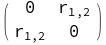
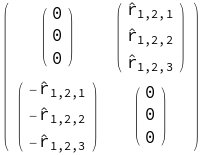
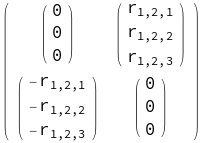

In [87]:
(* distance between nodes *)
ClearAll@r
ClearAll@DefineR

DefineR[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    rnm0,
    urh0,
    rnmv0
  },

  rnm0 = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[r, i, j], {Nn, Nn}, Symmetric[{1, 2}]];

  (* https://mathematica.stackexchange.com/questions/92666/how-to-zero-or-replace-the-diagonal-of-a-square-matrix *)
  (* rnm0 = ReplacePart[rnm0, {i_, i_} -> 0]; *)
  rnm0 = UpperTriangularize[rnm0, 1] + LowerTriangularize[rnm0, -1];

  (* unit vector r with hat *)
  (* h means hat *)
  urh0 = Normal@ SymmetrizedArray[{i_, j_, k_} -> Subscript[OverHat[r], i, j, k], {Nn, Nn, 3}, Antisymmetric[{1, 2}]];

  rnmv0 = Normal@ SymmetrizedArray[{i_, j_, k_} -> Subscript[r, i, j, k], {Nn, Nn, 3}, Antisymmetric[{1, 2}]];

  $Assumptions = AppendTo[
    $Assumptions,
    (* https://mathematica.stackexchange.com/questions/220317/how-to-best-add-assumption-that-many-variables-are-positive *)
    SparseArray[rnm0]["NonzeroValues"] \[Element] PositiveReals
  ];
  $Assumptions = Join[
    $Assumptions,
    Flatten@Table[urh0[[n, m, 1]]^2 + urh0[[n, m, 2]]^2 + urh0[[n, m, 3]]^2 == 1, {n, Nn}, {m, n+1, Nn}]
  ];

  {rnm0, urh0, rnmv0}
]

rAll = DefineR[Np];
rnm = rAll[[1]];
rnm // MatrixForm
urh = rAll[[2]];
urh // MatrixForm

rnmv0 = rAll[[3]];
rnmv0 // MatrixForm

$Assumptions

### Definition of dx

Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx        -Δx
   1,1,1      1,1,2      1,1,3
Δx                   Δx                   Δx
  2,1,1                2,1,2                2,1,3

Δx                   Δx                   Δx
  2,2,1                2,2,2                2,2,3

-Δx      - Δx        -Δx      - Δx        -Δx      - Δx
   2,1,1     2,2,1      2,1,2     2,2,2      2,1,3     2,2,3
{2, 3, 3}
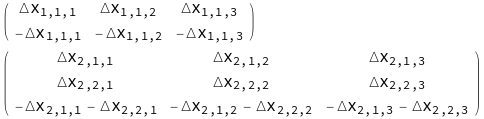

In [97]:
ClearAll@dx
ClearAll@DefineDx

DefineDx[Np_, com_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    dx0
  },

  (* dx the relative distance of each particle from the node centre of mass *)
  dx0 = Array[Subscript[\[CapitalDelta]x, ##] &, {Nn, maxNp, 3}];
  (* by determining the center of mass of the node *)
  Do[
    If[com[[n]],
      dx0[[n, Np[[n]]]] =
      If[
        Np[[n]] <= 1
        , {0, 0, 0}
        , - Sum[dx0[[n, p]], {p, Np[[n]] - 1}]
      ]
    ]
    , {n, 1, Nn}
  ];

  dx0
]

dx = DefineDx[Np, {True, True}];

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]

### Redefinition of quadrupole moments

2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    1,1,1        1,1,2        1,1,3         1,1,1   1,1,2
 

     6 Δx      Δx
>        1,1,1   1,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    1,1,1   1,1,2                            1,1,1        1,1,2        1,1,3
 

     6 Δx      Δx
>        1,1,2   1,1,3


6 Δx      Δx                            6 Δx      Δx
    1,1,1   1,1,3                           1,1,2   1,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         1,1,1        1,1,2        1,1,3
         2          2          2                         2            2      3 Δx      
2 Δx       - Δx       - Δx       + 2 (-Δx      - Δx     )  + 2 Δx       -        2,1,1
    2,1,1      2,1,2      2,1,3          2,1,1     2,2,1         2,2,1        
                                                                             >    Δx
                        2          2                       2          2             2,1,2
>   (-Δx      - Δx     )  - Δx       - (-Δx      - Δx     )  - Δx             
        2,1,2     2,2,2       2,2,2        2,1,3     2,2,3       2,2,3       >     + 3 
                                                                              
                                                                             >    (-Δx
                                                                              
                                                                             >      
                                                                                    2,1,1
                                                                              
                                                                             >       - Δx
                                                                              
                                                                             >      
                                                                                    2,2,1
                                                                              
                                                                             >      ) 
                                                                              
                                                                             >    (-Δx
                                                                              
                                                                             >      
                                                                                    2,1,2
                                                                              
                                                                             >       - Δx
                                                                              
                                                                             >      
                                                                                    2,2,2
                                                                              
                                                                             >      ) + 
                                                                              
                                                                             >   3 
                                                                              
                                                                             >    Δx
                                                                              
                                                                             >           
                                                                                   2,2,1
                                                                              
                            
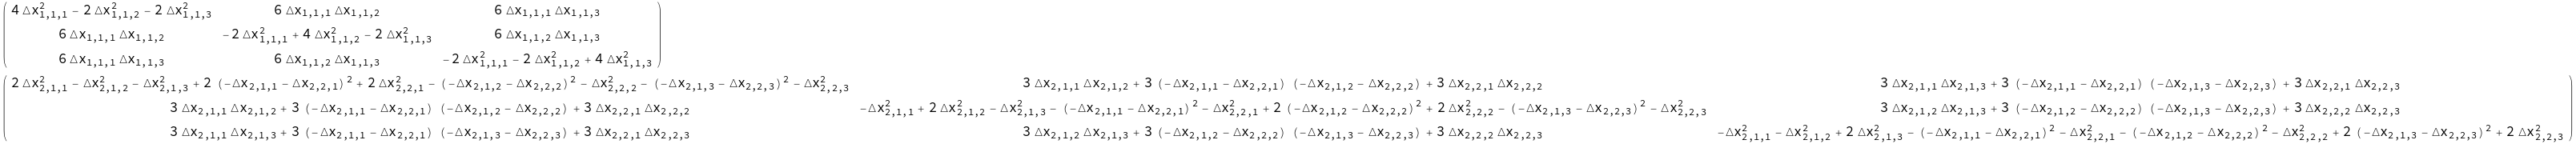
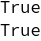
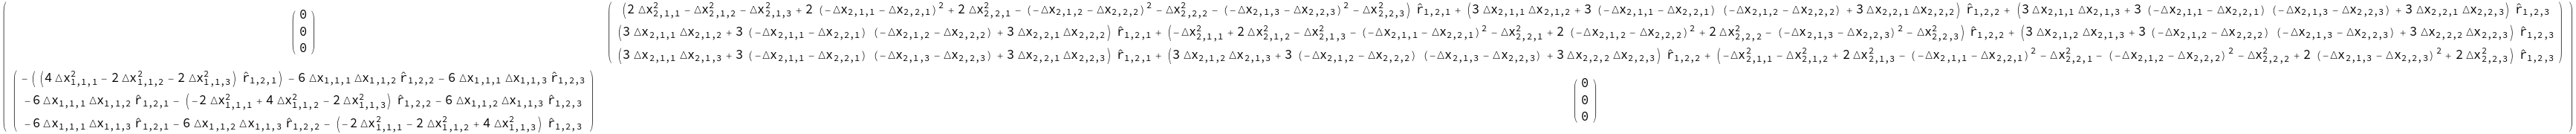
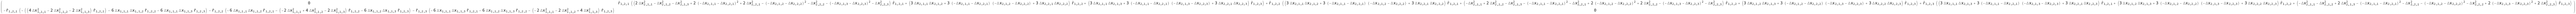

In [105]:
ClearAll@Qij
ClearAll@DefineQij

DefineQij[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    Qijp,
    Qij0,
    Qi0Full,
    Qi0,
    Q0Full,
    Q0,
    Qsp,
    Qsij0
  },

  Qijp = Array[3*dx[[#, #2, #3]]*dx[[#, #2, #4]] - SquareLength[dx[[#, #2]]]*KroneckerDelta[#3, #4] &, {Nn, maxNp, 3, 3}];
  Qij0 = Array[Subscript[Q, ##] &, {Nn, 3, 3}];
  Do[Qij0[[n]] = ParallelSum[Qijp[[n, p]], {p, Np[[n]]}], {n, 1, Nn}];

  Qi0Full = EinsteinSummation[{{n, m1, j}, {m2, i, j}}, {urh, Qij0}];
  (* get diagonal *)
  Qi0 = ParallelTable[Qi0Full[[n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  Q0Full = EinsteinSummation[{{n1, m1, i}, {n2, m2, j}, {m3, i, j}}, {urh, urh, Qij0}];
  (* get diagonal *)
  Q0 = ParallelTable[Q0Full[[n, m, n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  (* Dehnen, Marcello2017 *)
  (* specific quadrupole moment *)
  Qsp = Array[dx[[#, #2, #3]]*dx[[#, #2, #4]] &, {Nn, maxNp, 3, 3}];
  Qsij0 = Array[Subscript[Qs, ##] &, {Nn, 3, 3}];
  Do[Qsij0[[n]] = ParallelSum[Qsp[[n, p]], {p, Np[[n]]}], {n, 1, Nn}];

  {Qij0, Qi0, Q0, Qsij0}
]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
Column[Table[SymmetricMatrixQ[Qij[[n]]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, node m, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n, node m *)
Dimensions[Q]


### Node<sub>1</sub> <- Node<sub>2</sub> =? Node<sub>2</sub> <- Node<sub>1</sub>

#### Eq. 222

In [124]:
(* NB: without r *)

ClearAll@aMPhantom
aMPhantom[Np_] := Array[-Np[[#2]]*urh[[#, #2]] &, {Length[Np], Length[Np]}];

ClearAll@aQPhantom
aQPhantom[Np_] := Array[(Qi[[#, #2, #3]] - 5/2*urh[[#, #2, #3]]*Q[[#, #2]]) &, {Length[Np], Length[Np], 3}];

(* node n, node m, components a *)
Dimensions[aMPhantom[Np]]
Dimensions[aQPhantom[Np]]

{2, 2, 3}
{2, 2, 3}

#### 1 terms in eq. 228

In [126]:
ClearAll@fMPhantom
fMPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^2*Np[[n]]*aMPhantom[Np][[n, m]]

ClearAll@fQPhantom
fQPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^4*Np[[n]]*aQPhantom[Np][[n, m]]

#### Eq. 226

In [136]:
(* NB: without r *)

ClearAll@daMPhantom
daMPhantom[Np_] := Array[Np[[#2]]*(3*urh[[#, #2, #3]]*urh[[#, #2, #4]] - KroneckerDelta[#3, #4])
  &, {Length[Np], Length[Np], 3, 3}];

ClearAll@daQPhantom
daQPhantom[Np_] := Array[
  Qij[[#2, #3, #4]]
  + (35/2*urh[[#, #2, #3]]*urh[[#, #2, #4]] - 5/2*KroneckerDelta[#3, #4])*Q[[#, #2]]
  - 5*urh[[#, #2, #3]]*Qi[[#, #2, #4]] - 5*urh[[#, #2, #4]]*Qi[[#, #2, #3]]
  &, {Length[Np], Length[Np], 3, 3}];

(* node n, node m, components a, components r *)
Dimensions[daMPhantom[Np]]
Dimensions[daQPhantom[Np]]

{2, 2, 3, 3}
{2, 2, 3, 3}

#### 2 terms in eq. 228

In [149]:
ClearAll@a2MPhantomFull
a2MPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daMPhantom[Np]}];
ClearAll@a2MPhantom
(* get diagonal *)
a2MPhantom[Np_] := Table[a2MPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

ClearAll@a2QPhantomFull
a2QPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daQPhantom[Np]}];
ClearAll@a2QPhantom
(* get diagonal *)
a2QPhantom[Np_] := Table[a2QPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

(* node n, p from n, node m, components a *)
Dimensions[a2MPhantom[Np]]
Dimensions[a2QPhantom[Np]]

ClearAll@f2MPhantom
f2MPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^3*Sum[a2MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f2QPhantom
f2QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^5*Sum[a2QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 3, 2, 3}
{2, 3, 2, 3}

#### Eq. 227

In [161]:
(* NB: without r *)

ClearAll@d2aMPhantom
d2aMPhantom[Np_] := Array[
  Np[[#2]]*
  (5*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]
  - KroneckerDelta[#4, #5]*urh[[#, #2, #3]]
  - KroneckerDelta[#3, #5]*urh[[#, #2, #4]]
  - KroneckerDelta[#3, #4]*urh[[#, #2, #5]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

ClearAll@d2aQPhantom
d2aQPhantom[Np_] := Array[
  - 5*(urh[[#, #2, #5]]*Qij[[#2, #3, #4]] + urh[[#, #2, #3]]*Qij[[#2, #4, #5]] + urh[[#, #2, #4]]*Qij[[#2, #3, #5]])
  - 315/2*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]*Q[[#, #2]]
  + 35/2*(KroneckerDelta[#3, #4]*urh[[#, #2, #5]] + KroneckerDelta[#3, #5]*urh[[#, #2, #4]] + KroneckerDelta[#4, #5]*urh[[#, #2, #3]])*Q[[#, #2]]
  + 35*(urh[[#, #2, #4]]*urh[[#, #2, #5]]*Qi[[#, #2, #3]] + urh[[#, #2, #3]]*urh[[#, #2, #5]]*Qi[[#, #2, #4]] + urh[[#, #2, #3]]*urh[[#, #2, #4]]*Qi[[#, #2, #5]])
  - 5*(KroneckerDelta[#3, #4]*Qi[[#, #2, #5]] + KroneckerDelta[#3, #5]*Qi[[#, #2, #4]] + KroneckerDelta[#4, #5]*Qi[[#, #2, #3]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

(* node n, node m, components a, components r, components r *)
Dimensions[d2aMPhantom[Np]]
TensorRank[d2aMPhantom[Np]]
Dimensions[d2aQPhantom[Np]]
TensorRank[d2aQPhantom[Np]]

{2, 2, 3, 3, 3}
5
{2, 2, 3, 3, 3}
5

#### 3 terms in eq. 228

In [168]:
ClearAll@a3MPhantomFull
a3MPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aMPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3MPhantomFull[Np]]
TensorRank[a3MPhantomFull[Np]]

ClearAll@a3MPhantom
(* get diagonal *)
a3MPhantom[Np_] := ParallelTable[a3MPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3MPhantom[Np]]
TensorRank[a3MPhantom[Np]]

ClearAll@a3QPhantomFull
a3QPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aQPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3QPhantomFull[Np]]
TensorRank[a3QPhantomFull[Np]]

ClearAll@a3QPhantom
(* get diagonal *)
a3QPhantom[Np_] := ParallelTable[a3QPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3QPhantom[Np]]
TensorRank[a3QPhantom[Np]]

ClearAll@f3MPhantom
f3MPhantom[Np_, n_, m_] := -3/rnm[[n, m]]^4*Sum[a3MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f3QPhantom
f3QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^6*Sum[a3QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 3, 2, 3, 2, 2, 3}
7
{2, 3, 2, 3}
4
{2, 3, 2, 3, 2, 2, 3}
7
{2, 3, 2, 3}
4

#### Disbalances

##### 1 term disbalance

{0, 0, 0}
              2          2          2  ^
(6 (-2 Δx       + Δx       + Δx      ) r      - 
         1,1,1      1,1,2      1,1,3    1,2,1
 
                2          2             2                            2
>     4 (Δx       + Δx       - 2 (Δx       + Δx      Δx      + Δx      ) + 
           2,1,2      2,1,3         2,1,1      2,1,1   2,2,1     2,2,1
 
                                  2                            2  ^
>        Δx      Δx      + Δx       + Δx      Δx      + Δx      ) r      - 
           2,1,2   2,2,2     2,2,2      2,1,3   2,2,3     2,2,3    1,2,1
 
                         ^
>     18 Δx      Δx      r      + 6 
           1,1,1   1,1,2  1,2,2
 
                                                                       ^
>      (Δx      (2 Δx      + Δx     ) + Δx      (Δx      + 2 Δx     )) r      - 
          2,1,1      2,1,2     2,2,2      2,2,1    2,1,2       2,2,2    1,2,2
 
                         ^
>     18 Δx      Δx      r      + 6 
           1,1,1   1,1,3  1,2,3
 
                                                                       ^
>      (Δx      (2 Δx      + Δx     ) + Δx      (Δx      + 2 Δx     )) r      + 
          2,1,1      2,1,3     2,2,3      2,2,1    2,1,3       2,2,3    1,2,3
 
         ^                         ^      ^
>     15 r      (6 Δx      Δx      r      r      + 
          1,2,1      1,1,2   1,1,3  1,2,2  1,2,3
 
                   ^               ^                ^
>        6 Δx      r      (Δx      r      + Δx      r     ) - 
             1,1,1  1,2,1    1,1,2  1,2,2     1,1,3  1,2,3
 
                2  ^     2   ^     2     ^     2
>        Δx       (r       + r       - 2 r      ) + 
           1,1,3    1,2,1     1,2,2       1,2,3
 
                2    ^     2   ^     2   ^     2
>        Δx       (2 r       - r       - r      ) - 
           1,1,1      1,2,1     1,2,2     1,2,3
 
                2  ^     2     ^     2   ^     2
>        Δx       (r       - 2 r       + r      )) - 
           1,1,2    1,2,1       1,2,2     1,2,3
 
         ^                2 ^     2             2 ^     2          2 ^     2
>     10 r      (-(Δx       r      ) + 2 Δx       r       - Δx       r       - 
          1,2,1      2,1,3   1,2,1         2,2,1   1,2,1      2,2,2   1,2,1
 
                         ^     2          2 ^     2                     ^      ^
>        Δx      Δx      r       - Δx       r       + 6 Δx      Δx      r      r      - 
           2,1,3   2,2,3  1,2,1      2,2,3   1,2,1        2,2,1   2,2,2  1,2,1  1,2,2
 
                2 ^     2          2 ^     2            2 ^     2
>        Δx       r       - Δx       r       + 2 Δx       r       - 
           2,1,3   1,2,2      2,2,1   1,2,2        2,2,2   1,2,2
 
                         ^     2          2 ^     2
>        Δx      Δx      r       - Δx       r       + 
           2,1,3   2,2,3  1,2,2      2,2,3   1,2,2
 
                                          ^                ^       ^
>        3 (Δx      + 2 Δx     ) (Δx      r      + Δx      r     ) r      + 
              2,1,3       2,2,3     2,2,1  1,2,1     2,2,2  1,2,2   1,2,3
 
                  2          2             2                            2   ^     2
>        (-Δx       - Δx       + 2 (Δx       + Δx      Δx      + Δx      )) r       + 
             2,2,1      2,2,2         2,1,3      2,1,3   2,2,3     2,2,3     1,2,3
 
                2    ^     2   ^     2   ^     2
>        Δx       (2 r       - r       - r      ) - 
           2,1,1      1,2,1     1,2,2     1,2,3
 
                2  ^     2     ^     2   ^     2
>        Δx       (r       - 2 r       + r      ) + 
           2,1,2    1,2,1       1,2,2     1,2,3
 
                    ^                             ^
>        Δx      (3 r      ((2 Δx      + Δx     ) r      + 
           2,1,1     1,2,1       2,1,2     2,2,2   1,2,2
 
                                     ^                    ^     2   ^     2   ^     2
>              (2 Δx      + Δx     ) r     ) + Δx      (2 r       - r   
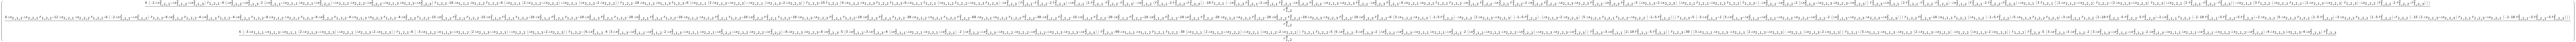

In [191]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancefQ] // MatrixForm

##### 2 term disbalance

In [194]:
ParallelMap[FullSimplify, {
  f2MPhantom[Np, 1, 2],
  f2MPhantom[Np, 2, 1],
  f2QPhantom[Np, 1, 2],
  f2QPhantom[Np, 2, 1]}
]

{{0, 0, 0}, {0, 0, 0}, {0, 0, 0}, {0, 0, 0}}

##### 3 term disbalance

2 ^                 2 ^                 2 ^                 2 ^
(3 (3 Δx       r      + 3 Δx       r      - 6 Δx       r      - 2 Δx       r      - 
        1,1,2   1,2,1       1,1,3   1,2,1       2,1,1   1,2,1       2,1,2   1,2,1
 
                 2 ^                          ^                 2 ^
>       2 Δx       r      - 6 Δx      Δx      r      - 6 Δx       r      - 
            2,1,3   1,2,1       2,1,1   2,2,1  1,2,1       2,2,1   1,2,1
 
                          ^                 2 ^                          ^
>       2 Δx      Δx      r      - 2 Δx       r      - 2 Δx      Δx      r      - 
            2,1,2   2,2,2  1,2,1       2,2,2   1,2,1       2,1,3   2,2,3  1,2,1
 
                 2 ^                  2 ^     3                      ^     3
>       2 Δx       r      + 10 Δx       r       + 10 Δx      Δx      r       + 
            2,2,3   1,2,1        2,1,1   1,2,1         2,1,1   2,2,1  1,2,1
 
                  2 ^     3            2 ^             ^     2
>       10 Δx       r       + 3 Δx       r      (3 - 5 r      ) - 
             2,2,1   1,2,1        1,1,1   1,2,1         1,2,1
 
                          ^                          ^                          ^
>       4 Δx      Δx      r      - 2 Δx      Δx      r      - 2 Δx      Δx      r      - 
            2,1,1   2,1,2  1,2,2       2,1,2   2,2,1  1,2,2       2,1,1   2,2,2  1,2,2
 
                          ^                           ^     2 ^
>       4 Δx      Δx      r      + 20 Δx      Δx      r       r      + 
            2,2,1   2,2,2  1,2,2        2,1,1   2,1,2  1,2,1   1,2,2
 
                           ^     2 ^                           ^     2 ^
>       10 Δx      Δx      r       r      + 10 Δx      Δx      r       r      + 
             2,1,2   2,2,1  1,2,1   1,2,2        2,1,1   2,2,2  1,2,1   1,2,2
 
                           ^     2 ^                  2 ^      ^     2
>       20 Δx      Δx      r       r      - 15 Δx       r      r       + 
             2,2,1   2,2,2  1,2,1   1,2,2        1,1,2   1,2,1  1,2,2
 
                  2 ^      ^     2                      ^      ^     2
>       10 Δx       r      r       + 10 Δx      Δx      r      r       + 
             2,1,2   1,2,1  1,2,2         2,1,2   2,2,2  1,2,1  1,2,2
 
                  2 ^      ^     2
>       10 Δx       r      r       + 
             2,2,2   1,2,1  1,2,2
 
>       2 ((Δx      (2 Δx      + Δx     ) + Δx      (Δx      + 2 Δx     )) 
              2,1,1      2,1,3     2,2,3      2,2,1    2,1,3       2,2,3
 
                    ^     2
>           (-1 + 5 r      ) + 5 (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
                     1,2,1             1,1,2   1,1,3     2,1,3      2,1,2     2,2,2
 
                                             ^      ^       ^
>             (Δx      + 2 Δx     ) Δx     ) r      r     ) r      + 
                 2,1,2       2,2,2    2,2,3   1,2,1  1,2,2   1,2,3
 
                     2             2                            2   ^      ^     2
>       5 (-3 Δx       + 2 (Δx       + Δx      Δx      + Δx      )) r      r       - 
                1,1,3         2,1,3      2,1,3   2,2,3     2,2,3     1,2,1  1,2,3
 
                          ^     2           ^                ^               4
>       6 Δx      (-1 + 5 r      ) (Δx      r      + Δx      r     ))) / r
            1,1,1          1,2,1      1,1,2  1,2,2     1,1,3  1,2,3       1,2

                       ^                          ^
(3 (-2 Δx      Δx      r      - 4 Δx      Δx      r      + 
         2,1,2   2,2,1  1,2,1       2,2,1   2,2,2  1,2,1
 
                    2          2  ^                 2 ^                 2 ^
>       3 (3 Δx       + Δx      ) r      - 6 Δx       r      - 2 Δx       r      - 
               1,1,2      1,1,3    1,2,2       2,1,2   1,2,2       2,1,3   1,2,2
 
                 2 ^                          ^                 2 ^
>       2 Δx       r      - 6 Δx      Δx      r      - 6 Δx       r      - 
            2,2,1   1,2,2       2,1,
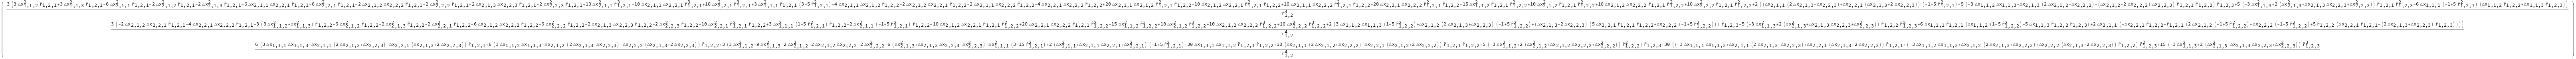

In [196]:
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancef3M] // MatrixForm

disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1];
FullSimplify[disbalancef3Q]

### Conclusion: node-node interaction are <span style="color:green">symmetric</span> up to 1/r^6!

In [199]:
FullSimplify[disbalancefQ + disbalancef3M]

{0, 0, 0}

### Particle in Node<sub>1</sub> <- Particle in Node<sub>2</sub> =? Particle in Node<sub>2</sub> <- Particle in Node<sub>1</sub>

r
0       1,2

r
 1,2   0
          ^
          r
0          1,2,1
          ^
          r
0          1,2,2
          ^
          r
0          1,2,3

 ^
-r
  1,2,1   0
 ^
-r
  1,2,2   0
 ^
-r
  1,2,3   0
Δx        Δx        Δx
  1,1,1     1,1,2     1,1,3
Δx        Δx        Δx
  2,1,1     2,1,2     2,1,3
         2          2          2
2 Δx       - Δx       - Δx          3 Δx      Δx
    1,1,1      1,1,2      1,1,3         1,1,1   1,1,2
 

     3 Δx      Δx
>        1,1,1   1,1,3

                                            2            2          2
3 Δx      Δx                        -Δx       + 2 Δx       - Δx
    1,1,1   1,1,2                      1,1,1        1,1,2      1,1,3
 

     3 Δx      Δx
>        1,1,2   1,1,3


3 Δx      Δx                        3 Δx      Δx
    1,1,1   1,1,3                       1,1,2   1,1,3
 
             2          2            2
     -Δx       - Δx       + 2 Δx
>       1,1,1      1,1,2        1,1,3
         2          2          2
2 Δx       - Δx       - Δx          3 Δx      Δx
    2,1,1      2,1,2      2,1,3         2,1,1   2,1,2
 

     3 Δx      Δx
>        2,1,1   2,1,3

                                            2            2          2
3 Δx      Δx                        -Δx       + 2 Δx       - Δx
    2,1,1   2,1,2                      2,1,1        2,1,2      2,1,3
 

     3 Δx      Δx
>        2,1,2   2,1,3


3 Δx      Δx                        3 Δx      Δx
    2,1,1   2,1,3                       2,1,2   2,1,3
 
             2          2            2
     -Δx       - Δx       + 2 Δx
>       2,1,1      2,1,2        2,1,3
              2          2          2  ^                          ^
    (2 Δx       - Δx       - Δx      ) r      + 3 Δx      Δx      r      + 
         2,1,1      2,1,2      2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                          ^
    >   3 Δx      Δx      r
            2,1,1   2,1,3  1,2,3
                      ^                 2            2          2  ^
    3 Δx      Δx      r      + (-Δx       + 2 Δx       - Δx      ) r      + 
        2,1,1   2,1,2  1,2,1       2,1,1        2,1,2      2,1,3    1,2,2
     
                          ^
    >   3 Δx      Δx      r
            2,1,2   2,1,3  1,2,3
                      ^                          ^
    3 Δx      Δx      r      + 3 Δx      Δx      r      + 
        2,1,1   2,1,3  1,2,1       2,1,2   2,1,3  1,2,2
     
0                2          2            2  ^
0   >   (-Δx       - Δx       + 2 Δx      ) r
0           2,1,1      2,1,2        2,1,3    1,2,3

            2          2          2  ^                           ^
-((2 Δx       - Δx       - Δx      ) r     ) - 3 Δx      Δx      r      - 
       1,1,1      1,1,2      1,1,3    1,2,1        1,1,1   1,1,2  1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,1   1,1,3  1,2,3
                   ^                 2            2          2  ^
-3 Δx      Δx      r      - (-Δx       + 2 Δx       - Δx      ) r      - 
     1,1,1   1,1,2  1,2,1       1,1,1        1,1,2      1,1,3    1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,2   1,1,3  1,2,3
                   ^                          ^
-3 Δx      Δx      r      - 3 Δx      Δx      r      - 
     1,1,1   1,1,3  1,2,1       1,1,2   1,1,3  1,2,2
 
             2          2            2  ^                                    0
>   (-Δx       - Δx       + 2 Δx      ) r                                    0
        1,1,1      1,1,2        1,1,3    1,2,3                               0
0   ^                 2          2          2  ^                          ^
    r      ((2 Δx       - Δx       - Δx      ) r      + 3 Δx      Δx      r      + 
     1,2,1       2,1,1      2,1,2      2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                             ^
    >      3 Δx      Δx      r     ) + 
               2,1,1   2,1,3  1,2,3
     
        ^                         ^                 2            2          2  ^
    >   r      (3 Δx      Δx      r      
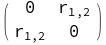
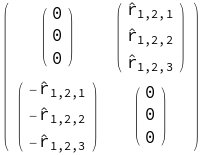
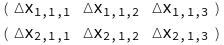
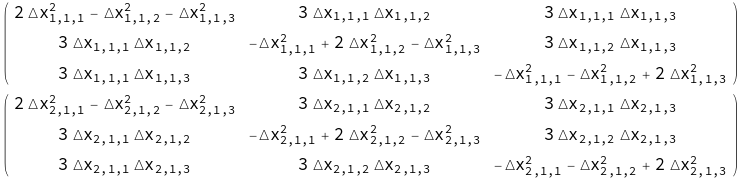
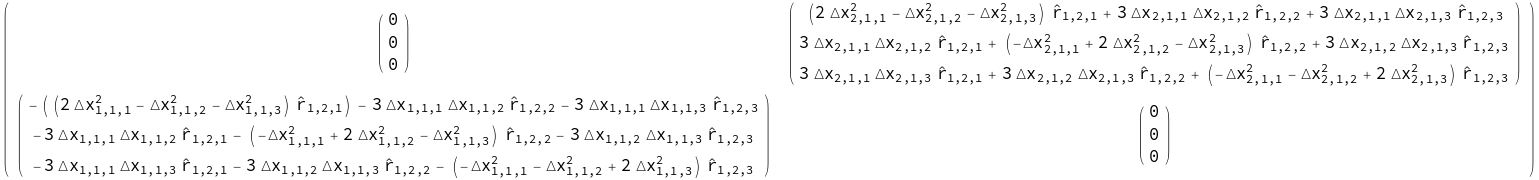
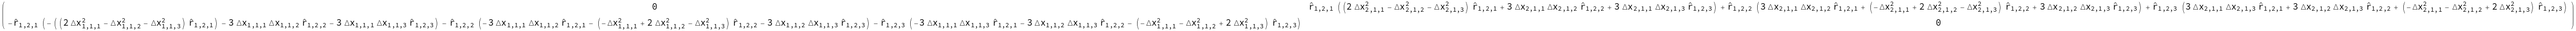

In [207]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

Np = {1, 1};
(* number of nodes *)
Nn = Length[Np];

rAll = DefineR[Np];

rnm = rAll[[1]];
rnm // MatrixForm

urh = rAll[[2]];
urh // MatrixForm

dx = DefineDx[Np, {False, False}];
Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm

Q = QijAll[[3]];
Q // MatrixForm

#### 1/r^2

In [219]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]

{0, 0, 0}

#### 1/r^3

^     2                         ^     2
(2 Δx      + 2 Δx      - 3 (Δx      + Δx     ) r       - 3 (Δx      + Δx     ) r       + 
     1,1,1       2,1,1        1,1,1     2,1,1   1,2,2         1,1,1     2,1,1   1,2,3
 
      ^                             ^                              ^              3
>     r      (3 (Δx      + Δx     ) r      + 3 (Δx      + Δx     ) r     )) / r
       1,2,1       1,1,2     2,1,2   1,2,2        1,1,3     2,1,3   1,2,3      1,2

                 ^     2                    ^     2
(Δx      (-1 + 3 r      ) + Δx      (-1 + 3 r      ) + 
   1,1,2          1,2,2       2,1,2          1,2,2
 
        ^                           ^                            ^              3
>     3 r      ((Δx      + Δx     ) r      + (Δx      + Δx     ) r     )) / r
         1,2,2     1,1,1     2,1,1   1,2,1      1,1,3     2,1,3   1,2,3      1,2

                                               ^                              ^
-((Δx      + Δx      + (-3 (Δx      + Δx     ) r      - 3 (Δx      + Δx     ) r     ) 
     1,1,3     2,1,3          1,1,1     2,1,1   1,2,1        1,1,2     2,1,2   1,2,2
 
         ^                              ^     2        3
>        r      - 3 (Δx      + Δx     ) r      ) / r    )
          1,2,3        1,1,3     2,1,3   1,2,3      1,2
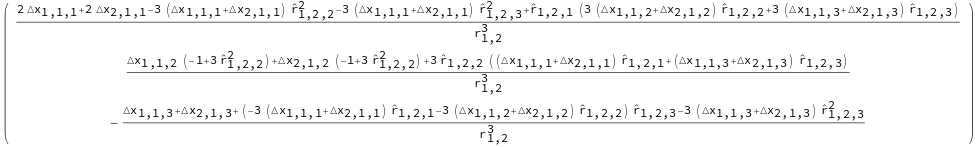

In [221]:
disbalance2fM = f2MPhantom[Np, 1, 2] + f2MPhantom[Np, 2, 1];
FullSimplify[disbalance2fM] // MatrixForm
(* ParallelMap[FullSimplify, disbalance2fM] // MatrixForm *)

#### 1/r^4

In [225]:
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
FullSimplify[disbalancefQ + disbalancef3M]

{0, 0, 0}

#### 1/r^5

2                  ^     2     ^     2
(-(Δx       (Δx      (2 + 10 r       - 5 r       + 
     1,1,2     2,1,1          1,2,2       1,2,3
 
                ^     2         ^     2      ^     2     ^     2
>             5 r       (-5 + 7 r       - 14 r       + 7 r      )) + 
                 1,2,1           1,2,1        1,2,2       1,2,3
 
             ^               ^              ^     2      ^     2     ^     2
>          5 r      (Δx      r      (-4 + 7 r       - 14 r       + 7 r      ) + 
              1,2,1    2,1,3  1,2,3          1,2,1        1,2,2       1,2,3
 
                      ^             ^     2      ^     2     ^     2
>             Δx      r      (2 + 7 r       - 14 r       + 7 r      )))) + 
                2,1,2  1,2,2         1,2,1        1,2,2       1,2,3
 
             2    ^               ^                ^
>     Δx       (5 r      (Δx      r      + Δx      r     ) 
        1,1,1      1,2,1    2,1,2  1,2,2     2,1,3  1,2,3
 
                   ^     2     ^     2     ^     2
>         (-2 + 14 r       - 7 r       - 7 r      ) + 
                    1,2,1       1,2,2       1,2,3
 
                         ^     4     ^     2     ^     2
>        Δx      (4 + 70 r       + 5 r       + 5 r       - 
           2,1,1          1,2,1       1,2,2       1,2,3
 
              ^     2         ^     2     ^     2
>           5 r       (10 + 7 r       + 7 r      ))) - 
               1,2,1           1,2,2       1,2,3
 
                        2 ^      ^              ^     2     ^     2     ^     2
>     Δx      (5 Δx       r      r      (2 - 14 r       + 7 r       + 7 r      ) + 
        1,1,3      2,1,1   1,2,1  1,2,3          1,2,1       1,2,2       1,2,3
 
           ^              2 ^             ^     2     ^     2      ^     2
>        5 r      (Δx       r      (2 + 7 r       + 7 r       - 14 r      ) + 
            1,2,1    2,1,3   1,2,3         1,2,1       1,2,2        1,2,3
 
                              ^             ^     2
>           6 Δx      Δx      r      (1 - 7 r      ) + 
                2,1,2   2,1,3  1,2,2         1,2,3
 
                   2 ^              ^     2      ^     2     ^     2
>           Δx       r      (-4 + 7 r       - 14 r       + 7 r      )) + 
              2,1,2   1,2,3          1,2,1        1,2,2       1,2,3
 
                                 ^     2      ^     2
>        Δx      (Δx      (2 - 5 r       + 10 r       + 
           1,1,3    2,1,1         1,2,2        1,2,3
 
                 ^     2         ^     2     ^     2      ^     2
>              5 r       (-5 + 7 r       + 7 r       - 14 r      )) + 
                  1,2,1           1,2,1       1,2,2        1,2,3
 
              ^               ^              ^     2     ^     2      ^     2
>           5 r      (Δx      r      (-4 + 7 r       + 7 r       - 14 r      ) + 
               1,2,1    2,1,2  1,2,2          1,2,1       1,2,2        1,2,3
 
                       ^             ^     2     ^     2      ^     2
>              Δx      r      (2 + 7 r       + 7 r       - 14 r      ))) - 
                 2,1,3  1,2,3         1,2,1       1,2,2        1,2,3
 
                                      ^     2  ^      ^
>        6 Δx      (5 Δx      (-1 + 7 r      ) r      r      + 
             2,1,1      2,1,2          1,2,1    1,2,2  1,2,3
 
                           ^     2     ^     2         ^     2
>           Δx      (1 - 5 r       + 5 r       (-1 + 7 r      )))) + 
              2,1,3         1,2,3       1,2,1           1,2,3
 
                                         ^     2             ^     2  ^     2
>     Δx      (6 Δx      (Δx      (1 - 5 r       + 5 (-1 + 7 r      ) r      ) + 
        1,1,2      2,1,1    2,1,2         1,2,1               1,2,1    1,2,2
 
                                          ^     2  ^      ^
>           5 (Δx      + Δx     ) (-1 + 7 r      ) r      r     ) + 
                 1,1,3     2,1,3           1,2,1    1,2,2  1,2,3
 
                  2 ^      ^               ^     2    
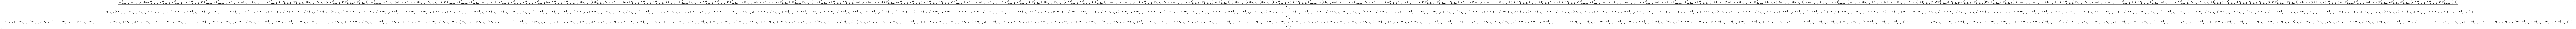

In [228]:
disbalance2fQ = f2QPhantom[Np, 1, 2] + f2QPhantom[Np, 2, 1];
(* FullSimplify[disbalance2fQ] // MatrixForm *)
ParallelMap[FullSimplify, disbalance2fQ] // MatrixForm

#### 1/r^6

In [230]:
disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1];
FullSimplify[disbalancef3Q]

{0, 0, 0}

### Particle in Node<sub>1</sub> <- Node<sub>2</sub> =? Node<sub>2</sub> <- Particle in Node<sub>1</sub>

r
0       1,2

r
 1,2   0
          ^
          r
0          1,2,1
          ^
          r
0          1,2,2
          ^
          r
0          1,2,3

 ^
-r
  1,2,1   0
 ^
-r
  1,2,2   0
 ^
-r
  1,2,3   0
Δx        Δx        Δx
  1,1,1     1,1,2     1,1,3
Δx         Δx         Δx
  2,1,1      2,1,2      2,1,3

-Δx        -Δx        -Δx
   2,1,1      2,1,2      2,1,3
         2          2          2
2 Δx       - Δx       - Δx          3 Δx      Δx
    1,1,1      1,1,2      1,1,3         1,1,1   1,1,2
 

     3 Δx      Δx
>        1,1,1   1,1,3

                                            2            2          2
3 Δx      Δx                        -Δx       + 2 Δx       - Δx
    1,1,1   1,1,2                      1,1,1        1,1,2      1,1,3
 

     3 Δx      Δx
>        1,1,2   1,1,3


3 Δx      Δx                        3 Δx      Δx
    1,1,1   1,1,3                       1,1,2   1,1,3
 
             2          2            2
     -Δx       - Δx       + 2 Δx
>       1,1,1      1,1,2        1,1,3
         2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    2,1,1        2,1,2        2,1,3         2,1,1   2,1,2
 

     6 Δx      Δx
>        2,1,1   2,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    2,1,1   2,1,2                            2,1,1        2,1,2        2,1,3
 

     6 Δx      Δx
>        2,1,2   2,1,3


6 Δx      Δx                            6 Δx      Δx
    2,1,1   2,1,3                           2,1,2   2,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         2,1,1        2,1,2        2,1,3
              2            2            2  ^                          ^
    (4 Δx       - 2 Δx       - 2 Δx      ) r      + 6 Δx      Δx      r      + 
         2,1,1        2,1,2        2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                          ^
    >   6 Δx      Δx      r
            2,1,1   2,1,3  1,2,3
                      ^                   2            2            2  ^
    6 Δx      Δx      r      + (-2 Δx       + 4 Δx       - 2 Δx      ) r      + 
        2,1,1   2,1,2  1,2,1         2,1,1        2,1,2        2,1,3    1,2,2
     
                          ^
    >   6 Δx      Δx      r
            2,1,2   2,1,3  1,2,3
                      ^                          ^
    6 Δx      Δx      r      + 6 Δx      Δx      r      + 
        2,1,1   2,1,3  1,2,1       2,1,2   2,1,3  1,2,2
     
0                  2            2            2  ^
0   >   (-2 Δx       - 2 Δx       + 4 Δx      ) r
0             2,1,1        2,1,2        2,1,3    1,2,3

            2          2          2  ^                           ^
-((2 Δx       - Δx       - Δx      ) r     ) - 3 Δx      Δx      r      - 
       1,1,1      1,1,2      1,1,3    1,2,1        1,1,1   1,1,2  1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,1   1,1,3  1,2,3
                   ^                 2            2          2  ^
-3 Δx      Δx      r      - (-Δx       + 2 Δx       - Δx      ) r      - 
     1,1,1   1,1,2  1,2,1       1,1,1        1,1,2      1,1,3    1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,2   1,1,3  1,2,3
                   ^                          ^
-3 Δx      Δx      r      - 3 Δx      Δx      r      - 
     1,1,1   1,1,3  1,2,1       1,1,2   1,1,3  1,2,2
 
             2          2            2  ^                                    0
>   (-Δx       - Δx       + 2 Δx      ) r                                    0
        1,1,1      1,1,2        1,1,3    1,2,3                               0
    ^                 2            2            2  ^                          ^
    r      ((4 Δx       - 2 Δx       - 2 Δx      ) r      + 6 Δx      Δx      r      + 
     1,2,1       2,1,1        2,1,2        2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                             ^
    >      6 Δx      Δx      r     ) +
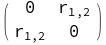
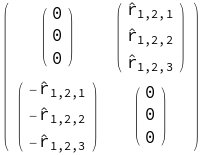
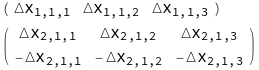
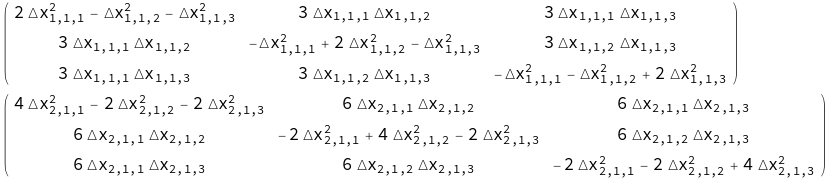
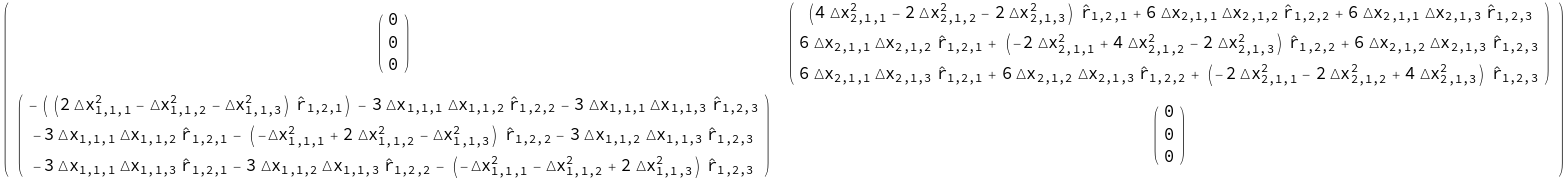
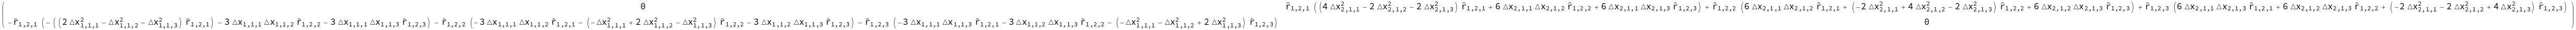

In [238]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

Np = {1, 2};
(* number of nodes *)
Nn = Length[Np];

rAll = DefineR[Np];

rnm = rAll[[1]];
rnm // MatrixForm

urh = rAll[[2]];
urh // MatrixForm

dx = DefineDx[Np, {False, True}];
Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm

Q = QijAll[[3]];
Q // MatrixForm

#### 1/r^2

In [250]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]

{0, 0, 0}

#### 1/r^3

^     2      ^               ^                ^
Δx      (-2 + 6 r      ) + 6 r      (Δx      r      + Δx      r     )
  1,1,1          1,2,1        1,2,1    1,1,2  1,2,2     1,1,3  1,2,3
---------------------------------------------------------------------
                                    3
                                r
                                 1,2

                ^     2      ^               ^                ^
Δx      (-2 + 6 r      ) + 6 r      (Δx      r      + Δx      r     )
  1,1,2          1,2,2        1,2,2    1,1,1  1,2,1     1,1,3  1,2,3
---------------------------------------------------------------------
                                    3
                                r
                                 1,2

           ^                ^       ^                        ^     2
6 (Δx      r      + Δx      r     ) r      + Δx      (-2 + 6 r      )
     1,1,1  1,2,1     1,1,2  1,2,2   1,2,3     1,1,3          1,2,3
---------------------------------------------------------------------
                                    3
                                r
                                 1,2
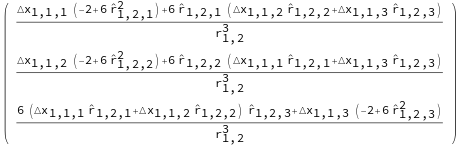

In [252]:
disbalance2fM = f2MPhantom[Np, 1, 2] + f2MPhantom[Np, 2, 1];
FullSimplify[disbalance2fM] // MatrixForm
(* ParallelMap[FullSimplify, disbalance2fM] // MatrixForm *)

#### 1/r^4

In [256]:
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
FullSimplify[disbalancefQ + disbalancef3M]

{0, 0, 0}

#### 1/r^5

^      ^              ^     2     ^     2
(3 (Δx      (-10 Δx      Δx      r      r      (-6 + 7 r       + 7 r      ) - 
      1,1,1        2,1,2   2,1,3  1,2,2  1,2,3          1,2,2       1,2,3
 
                      ^               ^                ^
>          10 Δx      r      (Δx      r      + Δx      r     ) 
                2,1,1  1,2,1    2,1,2  1,2,2     2,1,3  1,2,3
 
                    ^     2     ^     2
>           (-4 + 7 r       + 7 r      ) + 
                     1,2,2       1,2,3
 
                  2         ^     2            ^     2  ^     2      ^     4
>          Δx       (-4 + 5 r       - 35 (-1 + r      ) r       - 35 r      ) + 
             2,1,3           1,2,2              1,2,2    1,2,3        1,2,3
 
                  2         ^     2      ^     2       ^     2   ^     2
>          Δx       (-4 + 5 r       - 35 r       (-1 + r       + r      )) + 
             2,1,2           1,2,3        1,2,2         1,2,2     1,2,3
 
                  2         ^     4      ^     2      ^     4
>          Δx       (8 + 35 r       - 40 r       + 35 r       + 
             2,1,1           1,2,2        1,2,3        1,2,3
 
                 ^     2         ^     2
>             10 r       (-4 + 7 r      ))) + 
                  1,2,2           1,2,3
 
                           2 ^      ^              ^     2     ^     2
>       Δx      (-5 Δx       r      r      (-4 + 7 r       + 7 r      ) + 
          1,1,3       2,1,1   1,2,1  1,2,3          1,2,2       1,2,3
 
             ^              2         ^     2  ^
>          5 r      (Δx       (-1 + 7 r      ) r      + 
              1,2,1    2,1,2           1,2,2    1,2,3
 
                     2 ^              ^     2
>             Δx       r      (-3 + 7 r      ) + 
                2,1,3   1,2,3          1,2,3
 
                                ^              ^     2
>             2 Δx      Δx      r      (-1 + 7 r      )) + 
                  2,1,2   2,1,3  1,2,2          1,2,3
 
                                 ^      ^              ^     2     ^     2
>          2 Δx      (-5 Δx      r      r      (-6 + 7 r       + 7 r      ) + 
               2,1,1       2,1,2  1,2,2  1,2,3          1,2,2       1,2,3
 
                              ^     2            ^     2  ^     2      ^     4
>             Δx      (-4 + 5 r       - 35 (-1 + r      ) r       - 35 r      ))) - 
                2,1,3          1,2,2              1,2,2    1,2,3        1,2,3
 
                          2 ^      ^              ^     2     ^     2
>       Δx      (5 Δx       r      r      (-4 + 7 r       + 7 r      ) + 
          1,1,2      2,1,1   1,2,1  1,2,2          1,2,2       1,2,3
 
             ^              2 ^             ^     2
>          5 r      (Δx       r      (3 - 7 r      ) + 
              1,2,1    2,1,2   1,2,2         1,2,2
 
                                       ^     2  ^               2 ^             ^     2
>             2 Δx      Δx      (1 - 7 r      ) r      + Δx       r      (1 - 7 r      ))
                  2,1,2   2,1,3         1,2,2    1,2,3     2,1,3   1,2,2         1,2,3
 
                                    ^      ^              ^     2     ^     2
>            + 2 Δx      (5 Δx      r      r      (-6 + 7 r       + 7 r      ) + 
                   2,1,1      2,1,3  1,2,2  1,2,3          1,2,2       1,2,3
 
                             ^     2      ^     2       ^     2   ^     2             5
>             Δx      (4 - 5 r       + 35 r       (-1 + r       + r      )))))) / r
                2,1,2         1,2,3        1,2,2         1,2,2     1,2,3           1,2

                    2         ^     2      ^     4
(3 (Δx      (Δx       (3 - 30 r       + 35 r      ) + 
      1,1,2    2,1,2           1,2,2        1,2,2
 
                              ^              ^     2  ^
>          10 Δx      Δx      r      (-3 + 7 r      ) r      + 
                2,1,2   2,1,3  1,2,2          1,2,2    1,2,3
 
                      ^               ^              ^     2

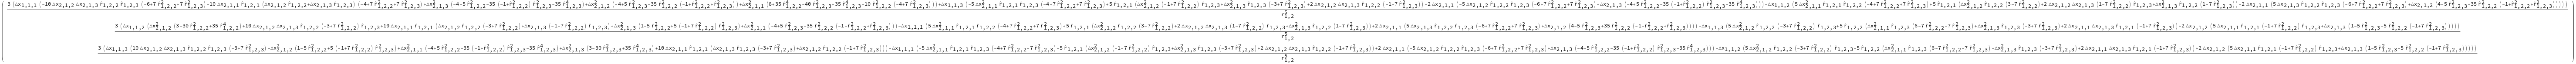

In [258]:
disbalance2fQ = f2QPhantom[Np, 1, 2] + f2QPhantom[Np, 2, 1];
FullSimplify[disbalance2fQ] // MatrixForm
(* ParallelMap[FullSimplify, disbalance2fQ] // MatrixForm *)

#### 1/r^6

In [261]:
disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1];
FullSimplify[disbalancef3Q]

{0, 0, 0}

## Additional force due to asymmetry of the tree

0                                         1









0                                         0









0                                         0
 
                                                                Δx
                                                                  2,1,1
                                                         r    - -------
                                                          1,2      2
               r    + Δx                       ----------------------------------
                1,2     2,1,1                                                  2
     ----------------------------------                     Δx          Δx
                 2                   2                        2,1,1 2     2,1,1
     Sqrt[Δx       + (r    + Δx     ) ]        Sqrt[(r    - -------)  + --------]
            2,1,1      1,2     2,1,1                  1,2      2           4


                                                                 Δx
                                                 1                 2,1,1
                  Δx                           -(-) ----------------------------------
                    2,1,1                        2                                  2
     ----------------------------------                          Δx          Δx
                 2                   2                             2,1,1 2     2,1,1
     Sqrt[Δx       + (r    + Δx     ) ]             Sqrt[(r    - -------)  + --------]
            2,1,1      1,2     2,1,1                       1,2      2           4









>    0                                         0










-1                                        0









0                                         0









0                                         0
 







     ^                                         ^
     r                                         r
      2,3,1                                     2,4,1







     ^                                         ^
     r                                         r
      2,3,2                                     2,4,2









>    0                                         0





            r    + Δx
             1,2     2,1,1
-(----------------------------------)
              2                   2        ^
  Sqrt[Δx       + (r    + Δx     ) ]      -r
         2,1,1      1,2     2,1,1           2,3,1




               Δx
                 2,1,1
-(----------------------------------)
              2                   2        ^
  Sqrt[Δx       + (r    + Δx     ) ]      -r
         2,1,1      1,2     2,1,1           2,3,2









0                                         0
 







                                               ^
                                               r
     0                                          3,4,1







                                               ^
                                               r
     0                                          3,4,2









>    0                                         0

                   Δx
                     2,1,1
            r    - -------
             1,2      2
-(----------------------------------)
                                  2
               Δx          Δx
                 2,1,1 2     2,1,1         ^
  Sqrt[(r    - -------)  + --------]      -r
         1,2      2           4             2,4,1


              Δx
                2,1,1
------------------------------------
                                  2
               Δx          Δx
                 2,1,1 2     2,1,1         ^
2 Sqrt[(r    - -------)  + --------]      -r
         1,2      2           4             2,4,2









0                                         0
 







      ^
     -r
       3,4,1                                   0







      ^
     -r
       3,4,2                                   0









>    0                                         0
Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx   
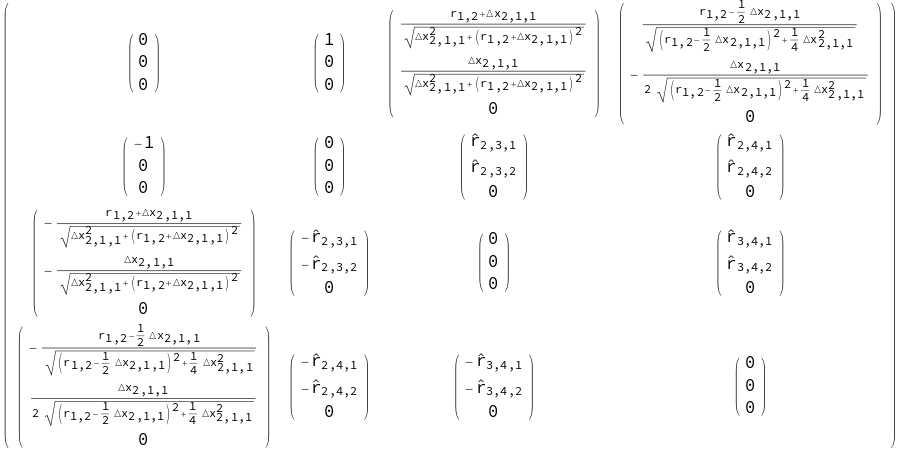
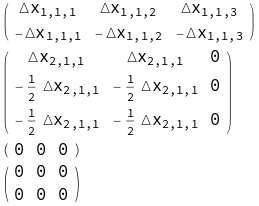
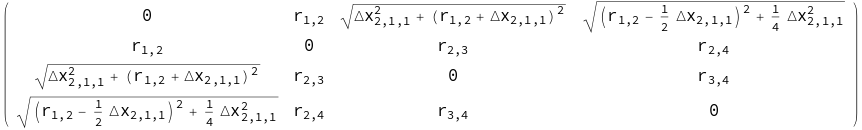
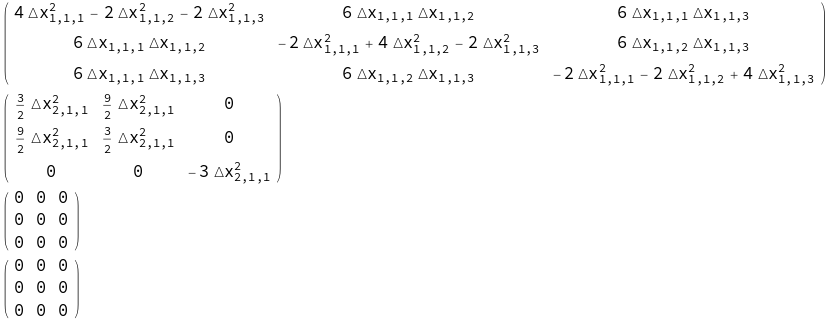
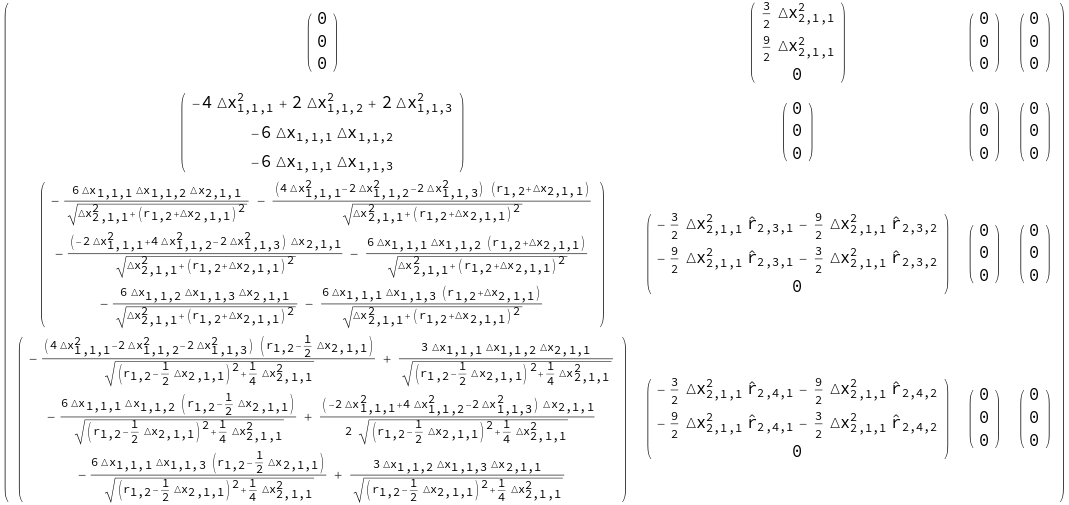
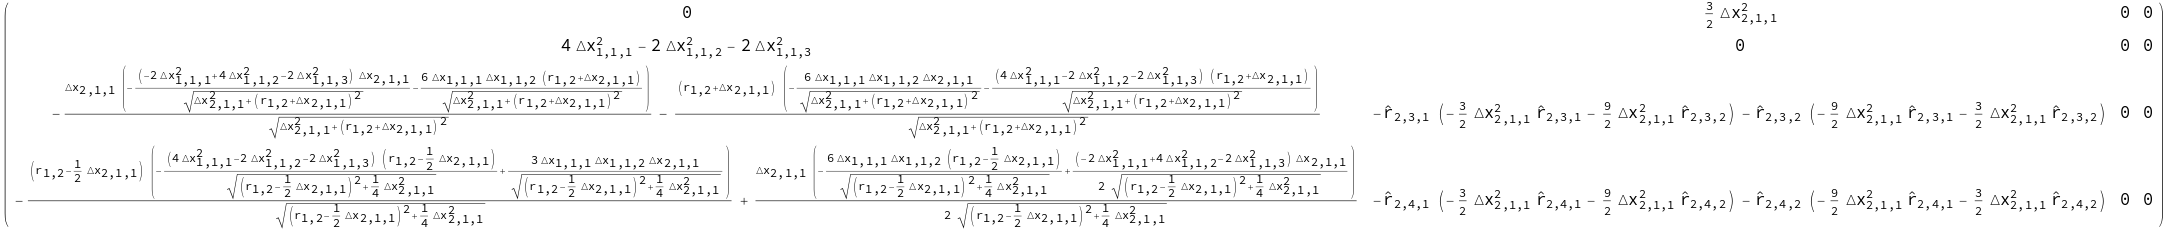

In [290]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* system of 4 nodes
A <- B(b1, b2)
b1 <- A
b2 <- A *)
(* Np = {A, B, b1, b2}; *)
Np = {2, 3, 1, 2};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

rAll = DefineR[Np];
rnm = rAll[[1]];
urh = rAll[[2]];

dx = DefineDx[Np, {True, True, True, True}];

TaylorExpansionRules = MapIndexed[
  (* # -> t*rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &, *)
  # -> t*rnm[[1, 2]]*Subscript[\[Delta]y, #[[-3]], #[[-2]], #[[-1]]] &,
  Flatten@Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]
];

(* Simplification *)

(* 3, 4 subnodes are collapsed to dots *)
dx[[3;;4, All, All]] = 0;
(* supernode 2 *)
dx[[2;;4, All, 3]] = 0;
(* unit r *)
urh[[All, All, 3]] = 0;
urh[[1, 2, 1]] = 1;
urh[[2, 1, 1]] = -1;
urh[[1;;2, 1;;2, 2]] = 0;

case = 3;

If[case == 1,
(
(* 1 case: Assume all nodes are along the x axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 1]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 1]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 2]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = rnm[[1, 2]] + dx[[2, 1, 1]];
rnm[[1, 4]] = rnm[[1, 2]] + dx[[2, Np[[2]], 1]];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[All, All, 2]] = 0;
Do[urh[[n, m, 1]] = 1, {n, 1, Length[Np]}, {m, n + 1, Length[Np]}];
Do[urh[[n, m, 1]] = -1, {m, 1, Length[Np]}, {n, m + 1, Length[Np]}];
)
]

If[case == 2,
(
(* 2 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are along the y axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 2]] = dx[[2, 1, 2]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 2]] = -dx[[2, 1, 2]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 1]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = rnm[[1, 2]]/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];
urh[[1, 4, 1]] = rnm[[1, 2]]/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

If[case == 3,
(
(* 3 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are located at an angle to the x and y axes *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], {1, 2}]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], {1, 2}]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[(rnm[[1, 2]] + dx[[2, 1, 1]])^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[(rnm[[1, 2]] + dx[[2, Np[[2]], 1]])^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = (rnm[[1, 2]] + dx[[2, 1, 1]])/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];

urh[[1, 4, 1]] = (rnm[[1, 2]] + dx[[2, Np[[2]], 1]])/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

urh //MatrixForm

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
rnm // MatrixForm

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm

Q = QijAll[[3]];
Q // MatrixForm

-6
-----
    2
r
 1,2





0





0
          2
-9 δy
     2,1,1
-----------
        2
  2 r
     1,2

         2
9 δy
    2,1,1
----------
      2
  r
   1,2







0
0

0

0
0

0

0
             2          2          2
9 (-2 δy       + δy       + δy      )
        1,1,1      1,1,2      1,1,3
-------------------------------------
                    2
                r
                 1,2


18 δy      δy
     1,1,1   1,1,2
------------------
          2
      r
       1,2


18 δy      δy
     1,1,1   1,1,3
------------------
          2
      r
       1,2
0

0

0

2 + δy      (-4 + δy      (3 + 4 δy     ))
      2,1,1         2,1,1          2,1,1
------------------------------------------
                      2
                  r
                   1,2

                                  2
δy      (2 - 6 δy      + 9 δy      )
  2,1,1          2,1,1       2,1,1
------------------------------------
                   2
               r
                1,2







0
        2
(δy       (6 - 24 δy     ) + 24 δy      δy      δy      + 
   1,1,1            2,1,1         1,1,1   1,1,2   2,1,1
 
                2          2                          2
>     3 (δy       + δy      ) (-1 + 4 δy     )) / r
           1,1,2      1,1,3             2,1,1      1,2

           2                       2          2
(12 δy       δy      - 3 (3 δy       + δy      ) δy      + 
      1,1,1    2,1,1          1,1,2      1,1,3     2,1,1
 
                                                2
>     6 δy      δy      (-1 + 4 δy     )) / r
          1,1,1   1,1,2           2,1,1      1,2

-6 δy      (δy      (1 - 4 δy     ) + δy      δy     )
     1,1,3    1,1,1          2,1,1      1,1,2   2,1,1
------------------------------------------------------
                            2
                        r
                         1,2
0

0

0
0

0

0
0

0

0
0

0

0
8 + δy      (8 + (3 - 2 δy     ) δy     )
      2,1,1               2,1,1    2,1,1
-----------------------------------------
                       2
                 2 r
                    1,2

     δy      (8 + 3 δy      (4 + 3 δy     ))
  1    2,1,1          2,1,1          2,1,1
-(-) ---------------------------------------
  4                       2
                      r
                       1,2






0
                                         2          2
(6 (-4 δy      δy      δy      - (δy       + δy      ) (1 + 2 δy     ) + 
         1,1,1   1,1,2   2,1,1      1,1,2      1,1,3            2,1,1
 
               2                         2
>       δy       (2 + 4 δy     ))) / r
          1,1,1           2,1,1       1,2

                                    2                                2          2
(-12 δy      δy      + 3 (-4 δy       - 8 δy      δy      + 3 δy       + δy      ) 
       1,1,1   1,1,2           1,1,1        1,1,1   1,1,2       1,1,2      1,1,3
 
                      2
>      δy     ) / r
         2,1,1     1,2

6 δy      (δy      δy      - 2 δy      (1 + 2 δy     ))
    1,1,3    1,1,2   2,1,1       1,1,1          2,1,1
-------------------------------------------------------
                             2
                         r
                          1,2
0

0

0
0

0

0
0

0

0
0

0

0
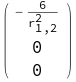
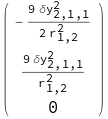
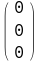
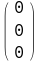
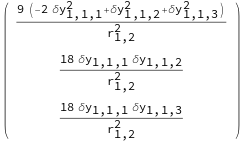
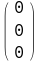
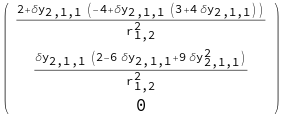
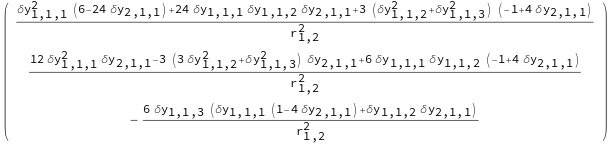
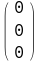
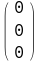
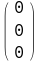
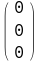
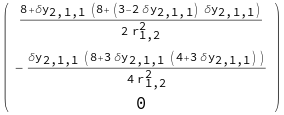
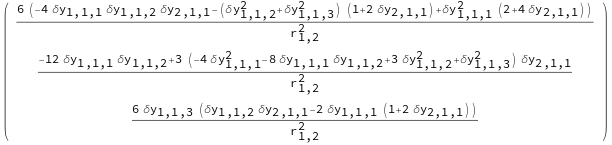
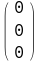
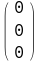
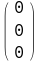
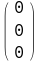

In [301]:
YTaylorExpansion[force_] := ParallelMap[
  Normal@Series[#,
    {t, 0, 3}
  ] /. t -> 1
  &,
  ReplaceAll[
    force
    , TaylorExpansionRules
  ]
]

YTaylorExpansion[fMPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[fQPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2MPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 1, 2]] // MatrixForm // FullSimplify
YTaylorExpansion[f3QPhantom[Np, 1, 2]] // MatrixForm // FullSimplify

YTaylorExpansion[fMPhantom[Np, 3, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[fQPhantom[Np, 3, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[f2MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 3, 1]] // MatrixForm

YTaylorExpansion[fMPhantom[Np, 4, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[fQPhantom[Np, 4, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[f2MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 4, 1]] // MatrixForm

3
3 δy
    2,1,1
----------
      2
  r
   1,2

          3
27 δy
     2,1,1
-----------
        2
  4 r
     1,2







0
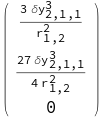

In [323]:
fAFromB = (fMPhantom[Np, 1, 2] + fQPhantom[Np, 1, 2]
  + f2MPhantom[Np, 1, 2] + f2QPhantom[Np, 1, 2]
  + f3MPhantom[Np, 1, 2] + f3QPhantom[Np, 1, 2]);
fb1FromA = (fMPhantom[Np, 3, 1] + fQPhantom[Np, 3, 1]
  + f2MPhantom[Np, 3, 1] + f2QPhantom[Np, 3, 1]
  + f3MPhantom[Np, 3, 1] + f3QPhantom[Np, 3, 1]);
fb2FromA = (fMPhantom[Np, 4, 1] + fQPhantom[Np, 4, 1]
  + f2MPhantom[Np, 4, 1] + f2QPhantom[Np, 4, 1]
  + f3MPhantom[Np, 4, 1] + f3QPhantom[Np, 4, 1]);

F = YTaylorExpansion[fAFromB + fb1FromA + fb2FromA];
F = FullSimplify[F] // MatrixForm

#### There <span style="color:red">IS</span> additional force even if the first node is collapsed into a dot

3
3 δy
    2,1,1
----------
      2
  r
   1,2

          3
27 δy
     2,1,1
-----------
        2
  4 r
     1,2







0
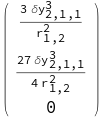

In [324]:
FullSimplify[
  F,
  Flatten@Table[Subscript[\[Delta]y, {1, p, i}] == 0, {p, Np[[1]]}, {i, 3}]
]

2
3 δy       (3 + 2 δy     )
    2,1,1           2,1,1
--------------------------
               2
         2 r
            1,2

         2
9 δy       (-4 + 3 δy     )
    2,1,1            2,1,1
---------------------------
                2
          4 r
             1,2







0
0

0

0
          2
-9 δy
     2,1,1
-----------
        2
  2 r
     1,2

         2
9 δy
    2,1,1
----------
      2
  r
   1,2







0
0

0

0
0

0

0
         3
3 δy
    2,1,1
----------
      2
  r
   1,2

          3
27 δy
     2,1,1
-----------
        2
  4 r
     1,2







0
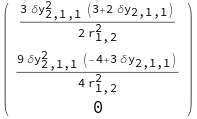
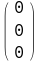
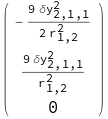
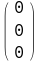
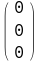
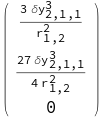

In [326]:
fr2 = fMPhantom[Np, 1, 2] + fMPhantom[Np, 3, 1] + fMPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr2 // MatrixForm
fr3 = f2MPhantom[Np, 1, 2] + f2MPhantom[Np, 3, 1] + f2MPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr3 // MatrixForm
fr4 = fQPhantom[Np, 1, 2] + fQPhantom[Np, 3, 1] + fQPhantom[Np, 4, 1] + f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 3, 1] + f3MPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr4 // MatrixForm
fr5 = f2QPhantom[Np, 1, 2] + f2QPhantom[Np, 3, 1] + f2QPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr5 // MatrixForm
fr6 = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 3, 1] + f3QPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr6 // MatrixForm

FullSimplify[fr2 + fr4 + fr6] // MatrixForm

### Conclusion: the main disbalance is dy^3 term

2            3
        9 δy         3 δy
  6         2,1,1        2,1,1
----- + ---------- + ----------
    2          2           2
r        2 r           r
 1,2        1,2         1,2

          2             3
-9 δy         27 δy
     2,1,1         2,1,1
----------- + -----------
       2              2
   r            4 r
    1,2            1,2







0
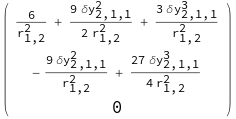

In [337]:
fr = fMPhantom[Np, 3, 1] + fMPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr // Expand // MatrixForm

{1, 2, 1, 1}
          4
10 δy
     2,1,1
-----------
       2
   r
    1,2
{1, 3, 2, 1}
          3
24 δy
     2,1,1
-----------
       2
   r
    1,2
{1, 3, 1, 2}
          3
-3 δy
     2,1,1
-----------
       2
   r
    1,2
{1, 2, 1, 1}
          4
15 δy
     2,1,1
-----------
        2
  4 r
     1,2
{1, 3, 2, 1}
         3
9 δy
    2,1,1
----------
      2
  r
   1,2
{1, 3, 1, 2}
         3
9 δy
    2,1,2
----------
       2
 8 r
    1,2
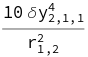
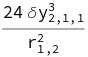
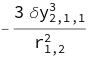
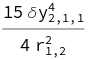
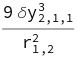
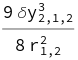

In [339]:
(* case 1 *)
Np = {1, 2, 1, 1}
addForce = 10*Subscript[\[Delta]y, 2, 1, 1]^4/Subscript[r, 1, 2]^2
Np = {1, 3, 2, 1}
addForce = 24*Subscript[\[Delta]y, 2, 1, 1]^3/Subscript[r, 1, 2]^2
Np = {1, 3, 1, 2}
addForce = -3*Subscript[\[Delta]y, 2, 1, 1]^3/Subscript[r, 1, 2]^2

(* case 2 *)
Np = {1, 2, 1, 1}
addForce = 15*Subscript[\[Delta]y, 2, 1, 1]^4/(4*Subscript[r, 1, 2]^2)
Np = {1, 3, 2, 1}
addForce = 9*Subscript[\[Delta]y, 2, 1, 1]^3/Subscript[r, 1, 2]^2
Np = {1, 3, 1, 2}
addForce = 9*Subscript[\[Delta]y, 2, 1, 2]^3/(8*Subscript[r, 1, 2]^2)

### Let's do this using symbolic calculations

3
           M  (r + Δx )           Abs[M ]  (-(r M ) + M  Δx )
            1        1                 2         2     1   1
M  (-(----------------------) + --------------------------------)
 0              2      2 3/2                    2     2    2 3/2
      ((r + Δx )  + Δy  )       ((r M  - M  Δx )  + M   Δy  )
              1       1              2    1   1      1    1

                                                           3
                                                    Abs[M ]
                      2      2 -(3/2)                    2
M  M  Δy  (-((r + Δx )  + Δy  )       + --------------------------------)
 0  1   1           1       1                           2     2    2 3/2
                                        ((r M  - M  Δx )  + M   Δy  )
                                             2    1   1      1    1
             2     2            2        2               2     2             2      2
 -2 M  M  (M   - M  ) Δx  (2 Δx   - 3 Δy  )  -3 M  M  (M   - M  ) Δy  (-4 Δx   + Δy  )
     0  1   1     2     1      1        1        0  1   1     2     1       1      1
{------------------------------------------, -----------------------------------------}
                    5   2                                       5   2
                   r  M                                      2 r  M
                       2                                           2
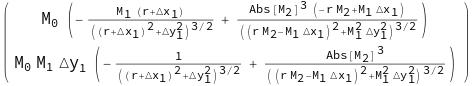
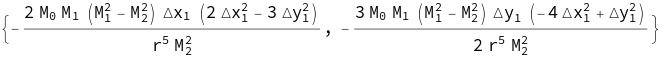

In [366]:
ClearAll@r

M0 = Subscript[M, 0];
M1 = Subscript[M, 1];
M2 = Subscript[M, 2];
dx1 = Subscript[\[CapitalDelta]x, 1];
dy1 = Subscript[\[CapitalDelta]y, 1];
dx2 = - dx1*M1/M2;
dy2 = - dy1*M1/M2;
r1 = {r + dx1, dy1};
r2 = {r + dx2, dy2};

$Assumptions = {
  _ \[Element] PositiveReals,
  r > 0,
  dx1 >= 0,
  dy1 >= 0
};

f1 = - M0*M1*r1/Norm[r1]^3;
f2 = - M0*M2*r2/Norm[r2]^3;

force = FullSimplify[f1 + f2];
force // MatrixForm

(* https://community.wolfram.com/groups/-/m/t/572931 *)
(* https://mathematica.stackexchange.com/questions/15023/multivariable-taylor-expansion-does-not-work-as-expected *)
ForceCoefficients = SeriesCoefficient[force /. Thread[{dx1, dy1} -> t {dx1, dy1}], {t, 0, 3}] // FullSimplify

3        2             6         4    2         2    4        6
Abs[M ] Abs[M   - M  M  ] Sqrt[64 Δx   - 48 Δx   Δy   + 72 Δx   Δy   + 9 Δy  ]
     0       1     1  2             1         1    1         1    1        1
------------------------------------------------------------------------------
                                      5   2
                                   2 r  M
                                         2
                    2
                  M
                   1       3
4 Abs[M  M  (-1 + ---)] Δx
       0  1         2     1
                  M
                   2
----------------------------
              5
             r
                3        2     3
3 Abs[M ] Abs[M   - M  M  ] Δy
       0       1     1  2     1
--------------------------------
               5   2
            2 r  M
                  2
                       3        2     3
Sqrt[97] Abs[M ] Abs[M   - M  M  ] Δx
              0       1     1  2     1
---------------------------------------
                  5   2
               2 r  M
                     2
                           3       3        2
             Sqrt[97] Abs[s  M  (M   - M  M  )]
                              0   1     1  2
{Piecewise[{{----------------------------------, 0 < M  < M  || M  > M }, 
                             5   2                    1    2     1    2
                          2 r  M
                                2
 
                                                      s
>     {0, M  == M }}, -Infinity], {Δx  -> Piecewise[{{-, M  == M }}, s], 
           1     2                   1                2   1     2
 
                        s
>    Δy  -> Piecewise[{{-, M  == M }}, s]}}
       1                2   1     2
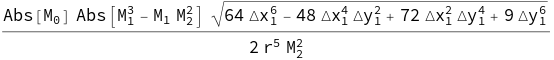
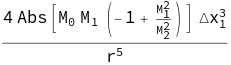
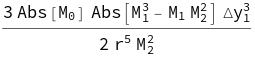
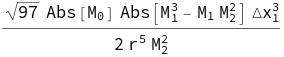
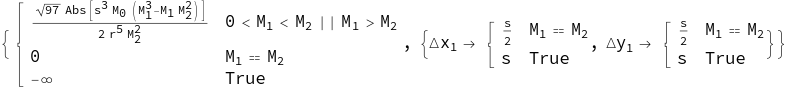

In [373]:
fx[dx_, dy_] := M0*(6*M1*((M1/M2)^2 - 1)dx*dy^2/r^5 - 4*M1*((M1/M2)^2 - 1)*dx^3/r^5)
fy[dx_, dy_] := M0*(6*M1*((M1/M2)^2 - 1)dx^2*dy/r^5 - 3/2*M1*((M1/M2)^2 - 1)*dy^3/r^5)

fd[dx_, dy_] := Sqrt[fx[dx, dy]^2 + fy[dx, dy]^2]

FullSimplify[fd[dx1, dy1]]

(* e.g. *)
(* MassReplacer = {M1 -> 1, M2 -> 2, M0 -> 1} *)
(* case 1 *)
(* fd[dx1, 0] /. MassReplacer // FullSimplify *)
fd[dx1, 0] // FullSimplify
(* case 2 *)
(* fd[0, dy1] /. MassReplacer // FullSimplify *)
fd[0, dy1] // FullSimplify
(* case 3 *)
(* fd[dx1, dx1] /. MassReplacer // FullSimplify *)
fd[dx1, dx1] // FullSimplify

Maximize[
  {fd[dx1, dy1],
    0 <= dx1 <= s,
    0 <= dy1 <= s,
    M0 > 0,
    M1 > 0,
    M2 > 0,
    s > 0,
    r > 0
  },
  {dx1, dy1}
] // FullSimplify

### Main Conclusion

3       3        2
Sqrt[97] Abs[s  M  (M   - M  M  )]
                 0   1     1  2
----------------------------------
                5   2
             2 r  M
                   2
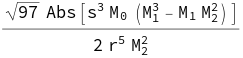

In [386]:
fd[s, s] // FullSimplify

# The time of migration of the center of mass of the star to a distance equal to the radius of the star

2
456 Sqrt[97] Pi M
                 star
----------------------
         3      2
     5 N   R
        p   star
             2
2821.83 M
         star
--------------
    3      2
  N   R
   p   star
   5   2/3   2      2
(-----)    N   R
 57 Pi      p   star
---------------------
      1/3      2/3
  4 97    M
           star
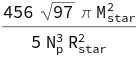
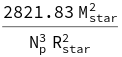
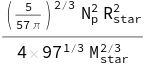

In [413]:
hfact = Subscript[h, fact];
(* mass of the star *)
Ms = Subscript[M, star];
(* radius of the star *)
Rs = Subscript[R, star];
(* number of all particle in the star *)
Np = Subscript[N, p];
(* mass of the sph particle *)
mp = Ms/Np;
rho = Ms/(4/3*\[Pi]*Rs^3);
hp = hfact*(mp/rho)^(1/3);

(* Simplifications *)

(* number of all particle in the node *)
Npn = Subscript[N, pn];

(* number of particles in leaf node *)
Npn = 10;

(* The min size of the node is accepted as distance between sph particles *)
s = 2*hp/hfact;

(* masses of the nodes *)
M0 = Npn*mp;
(* difference is only 1 particle *)
M1 = (Npn - 1)*mp;
M2 = Npn*mp;

(* distance between nodes is equal to star radius *)
r = Rs;

$Assumptions = Join[
  $Assumptions,
  {
    hfact > 0,
    Ms > 0,
    Rs > 0,
    Np > 0
  }
];

Fadd = FullSimplify[fd[s, s]]
Fadd // N

impulse = Fadd*\[Tau];
(* assumes that all impulses are uniformly distributed in time *)
\[Tau] = T/n;
v = impulse/Ms;
(* rcom = FullSimplify[Sqrt[1/3*v^2/\[Tau]^2*T^3]] *)
rcom = FullSimplify[Sqrt[v^2/\[Tau]^2*T^3]];

Tsol = Solve[rcom == Rs, {T}];
T = T/.Tsol[[1]]

2      2
0.00500779 N   R
            p   star
---------------------
           2/3
      M
       star
20031.2
          -6
3.52729 10
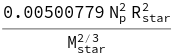

In [423]:
T = FullSimplify[T, {Np > 0, Npn > 0, s > 0, Ms > 0}] // N

NumericalRules = {
  Subscript[h, fact] == 1.2,
  Subscript[R, star] == 10,
  Subscript[M, star] == 1,
  Subscript[N, p] == 200
  };

FullSimplify[T, NumericalRules]
FullSimplify[Fadd, NumericalRules]

# Dehnen 2000, 2002, 2014; Marcello 2017

<!-- @article{Dehnen2000,
  title = {A {{Very Fast}} and {{Momentum-conserving Tree Code}}},
  author = {Dehnen, Walter},
  date = {2000-06-10},
  journaltitle = {The Astrophysical Journal},
  volume = {536},
  number = {1},
  pages = {L39-L42},
  issn = {0004637X},
  doi = {10.1086/312724},
  url = {https://iopscience.iop.org/article/10.1086/312724},
  keywords = {★,FMM,gravitaion,gravitation,N-body},
  annotation = {172 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/NSVC2Y2D/Dehnen - 2000 - A Very Fast and Momentum-conserving Tree Code.pdf}
} -->

<!-- @article{Dehnen2002,
  title = {A {{Hierarchical}} ({{N}}) {{Force Calculation Algorithm}}},
  author = {Dehnen, Walter},
  date = {2002-06},
  journaltitle = {Journal of Computational Physics},
  shortjournal = {Journal of Computational Physics},
  volume = {179},
  number = {1},
  eprint = {astro-ph/0202512},
  eprinttype = {arxiv},
  pages = {27--42},
  issn = {00219991},
  doi = {10.1006/jcph.2002.7026},
  abstract = {A novel code for the approximate computation of long-range forces between N mutually interacting bodies is presented. The code is based on a hierarchical tree of cubic cells and features mutual cell-cell interactions which are calculated via a Cartesian Taylor expansion in a symmetric way, such that total momentum is conserved. The code benefits from an improved and simple multipole acceptance criterion that reduces the force error and the computational effort. For N ≳ 104, the computational costs are found empirically to rise sublinearly with N. For applications in stellar dynamics, this is the first competitive code with complexity O(N); it is faster than the standard tree code by a factor of 10 or more. © 2002 Elsevier Science (USA).},
  langid = {english},
  keywords = {★,Adaptive algorithms,Fast multipole method,FMM,gravitaion,gravitation,N-body,N-body simulations,Tree code},
  annotation = {213 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/8JW2P7Y6/Dehnen - 2002 - A hierarchical O(N) force calculation algorithm.pdf}
} -->

<!-- @article{Dehnen2014,
  title = {A Fast Multipole Method for Stellar Dynamics},
  author = {Dehnen, Walter},
  date = {2014-09-11},
  journaltitle = {Computational Astrophysics and Cosmology},
  shortjournal = {Comput. Astrophys.},
  volume = {1},
  number = {1},
  pages = {1},
  issn = {2197-7909},
  doi = {10.1186/s40668-014-0001-7},
  url = {https://link.springer.com/10.1186/s40668-014-0001-7},
  urldate = {2024-03-23},
  abstract = {The approximate computation of all gravitational forces between N interacting particles via the fast multipole method (FMM) can be made as accurate as direct summation, but requires less than O(N) operations. FMM groups particles into spatially bounded cells and uses cell-cell interactions to approximate the force at any position within the sink cell by a Taylor expansion obtained from the multipole expansion of the source cell. By employing a novel estimate for the errors incurred in this process, I minimise the computational effort required for a given accuracy and obtain a well-behaved distribution of force errors. For relative force errors of ∼ 10–7, the computational costs exhibit an empirical scaling of ∝ N0.87. My implementation (running on a 16 core node) out-performs a GPU-based direct summation with comparable force errors for N 105.},
  langid = {english},
  keywords = {FMM,gravitaion,gravitation},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/KMEKGNZH/Dehnen - 2014 - A fast multipole method for stellar dynamics.pdf}
} -->

<!-- @article{Marcello2017,
  title = {A {{Very Fast}} and {{Angular Momentum Conserving Tree Code}}},
  author = {Marcello, Dominic C.},
  date = {2017-08-11},
  journaltitle = {The Astronomical Journal},
  shortjournal = {AJ},
  volume = {154},
  number = {3},
  pages = {92},
  issn = {0004-6256, 1538-3881},
  doi = {10.3847/1538-3881/aa7b2f},
  url = {https://iopscience.iop.org/article/10.3847/1538-3881/aa7b2f},
  urldate = {2024-03-23},
  abstract = {Abstract             There are many methods used to compute the classical gravitational field in astrophysical simulation codes. With the exception of the typically impractical method of direct computation, none ensure conservation of angular momentum to machine precision. Under uniform time-stepping, the Cartesian fast multipole method of Dehnen (also known as the very fast tree code) conserves linear momentum to machine precision. We show that it is possible to modify this method in a way that conserves both angular and linear momenta.},
  keywords = {gravitaion,gravitation},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/8TLCSC93/Marcello - 2017 - A Very Fast and Angular Momentum Conserving Tree Code.pdf}
} -->

^
          r
0          1,2,1
          ^
          r
0          1,2,2
          ^
          r
0          1,2,3

 ^
-r
  1,2,1   0
 ^
-r
  1,2,2   0
 ^
-r
  1,2,3   0
          r
0          1,2,1
          r
0          1,2,2
          r
0          1,2,3

-r
  1,2,1   0
-r
  1,2,2   0
-r
  1,2,3   0
Δx        Δx        Δx
  1,1,1     1,1,2     1,1,3
Δx         Δx         Δx
  2,1,1      2,1,2      2,1,3

-Δx        -Δx        -Δx
   2,1,1      2,1,2      2,1,3
^
r
 1,2,1
------
    2
r
 1,2

^
r
 1,2,2
------
    2
r
 1,2

^
r
 1,2,3
------
    2
r
 1,2
      ^     2         ^      ^           ^      ^
1 - 3 r            -3 r      r        -3 r      r
       1,2,1           1,2,1  1,2,2       1,2,1  1,2,3
-------------      ----------------   ----------------
        3                   3                  3
    r                   r                  r
     1,2                 1,2                1,2

   ^      ^              ^     2         ^      ^
-3 r      r        1 - 3 r            -3 r      r
    1,2,1  1,2,2          1,2,2           1,2,2  1,2,3
----------------   -------------      ----------------
         3                 3                   3
     r                 r                   r
      1,2               1,2                 1,2

   ^      ^           ^      ^              ^     2
-3 r      r        -3 r      r        1 - 3 r
    1,2,1  1,2,3       1,2,2  1,2,3          1,2,3
----------------   ----------------   -------------
         3                  3                 3
     r                  r                 r
      1,2                1,2               1,2
  ^              ^     2              ^     2  ^                  ^     2  ^
3 r      (-3 + 5 r      )   3 (-1 + 5 r      ) r        3 (-1 + 5 r      ) r
   1,2,1          1,2,1                1,2,1    1,2,2              1,2,1    1,2,3
-------------------------   -------------------------   -------------------------
              4                           4                           4
          r                           r                           r
           1,2                         1,2                         1,2
          ^     2  ^          ^              ^     2       ^      ^      ^
3 (-1 + 5 r      ) r        3 r      (-1 + 5 r      )   15 r      r      r
           1,2,1    1,2,2      1,2,1          1,2,2         1,2,1  1,2,2  1,2,3
-------------------------   -------------------------   -----------------------
              4                           4                          4
          r                           r                          r
           1,2                         1,2                        1,2
          ^     2  ^           ^      ^      ^            ^              ^     2
3 (-1 + 5 r      ) r        15 r      r      r          3 r      (-1 + 5 r      )
           1,2,1    1,2,3       1,2,1  1,2,2  1,2,3        1,2,1          1,2,3
-------------------------   -----------------------     -------------------------
              4                          4                            4
          r                          r                            r
           1,2                        1,2                          1,2

          ^     2  ^          ^              ^     2       ^      ^      ^
3 (-1 + 5 r      ) r        3 r      (-1 + 5 r      )   15 r      r      r
           1,2,1    1,2,2      1,2,1          1,2,2         1,2,1  1,2,2  1,2,3
-------------------------   -------------------------   -----------------------
              4                           4                          4
          r                           r                          r
           1,2                         1,2                        1,2
  ^              ^     2      ^              ^     2              ^     2  ^
3 r      (-1 + 5 r      )   3 r      (-3 + 5 r      )   3 (-1 + 5 r      ) r
   1,2,1          1,2,2        1,2,2          1,2,2                1,2,2    1,2,3
-------------------------   -------------------------   
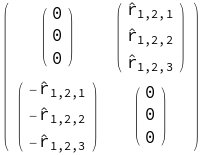
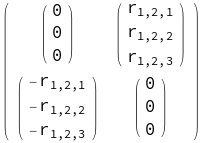
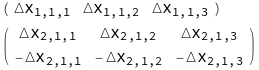
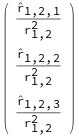
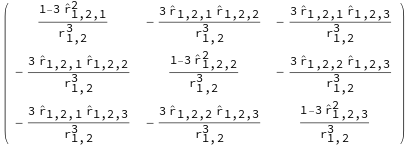
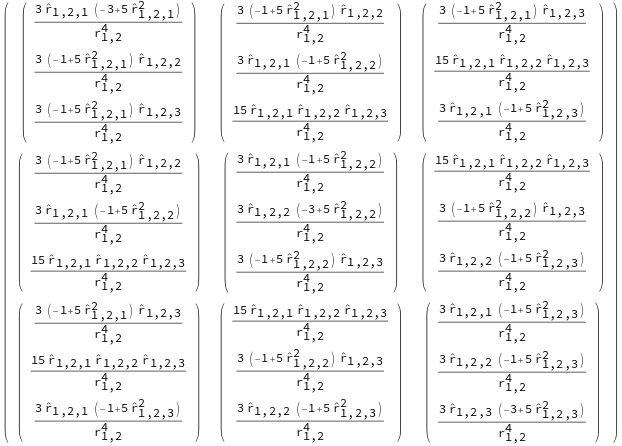
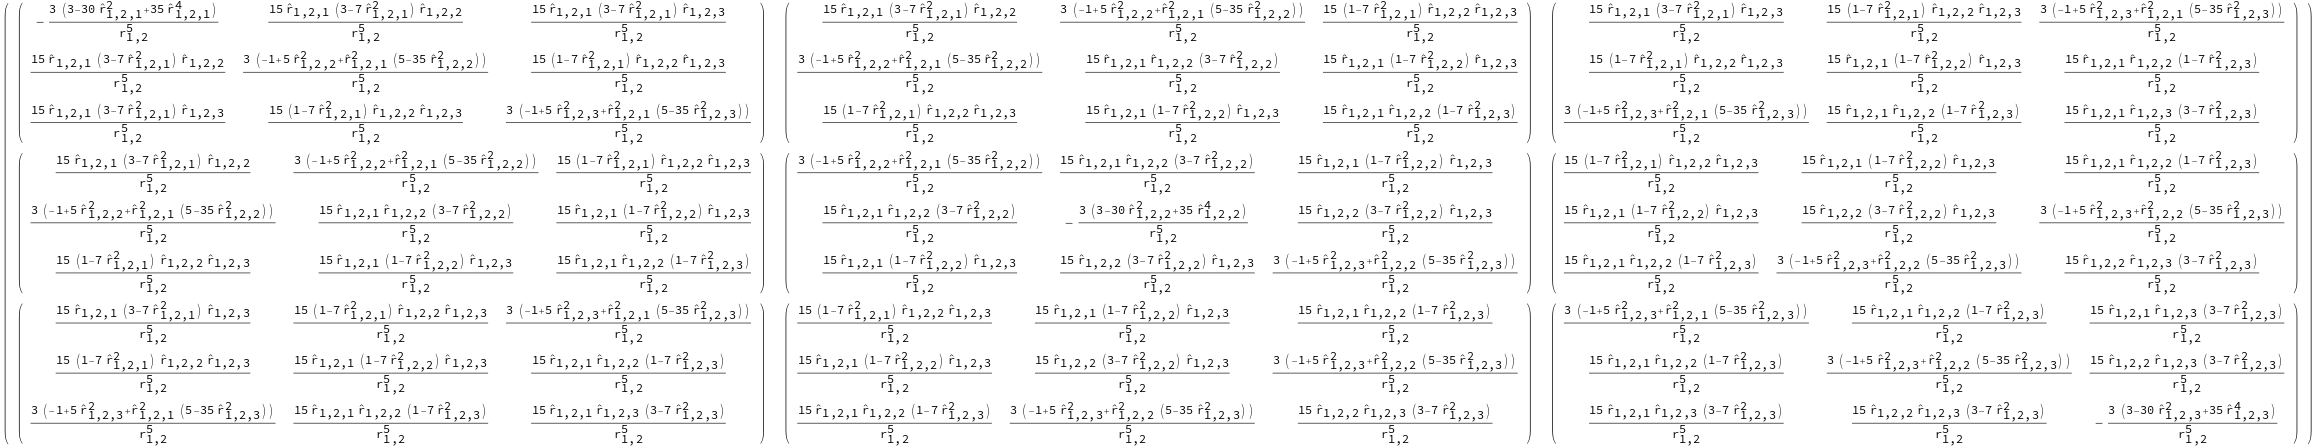

In [436]:
ClearAll@r

(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

Np = {1, 2};
(* number of nodes *)
Nn = Length[Np];

rAll = DefineR[Np];
rnm = rAll[[1]];
urh = rAll[[2]];
urh // MatrixForm
rnmv = rAll[[3]];
rnmv // MatrixForm

dx = DefineDx[Np, {False, True}];
Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]

RnmvRules = Flatten@Table[rnmv[[n, m, 1]]^2 + rnmv[[n, m, 2]]^2 + rnmv[[n, m, 3]]^2 -> rnm[[n, m]]^2, {n, Nn}, {m, n+1, Nn}];
RnmvRules = Join[RnmvRules, MapIndexed[
  # -> rnm[[1, 2]]*urh[[#[[-3]], #[[-2]], #[[-1]]]] &,
  Flatten@Table[rnmv[[n, m]], {n, 1, Nn}, {m, n + 1, Nn}]
]];

DGreen[n_, m_, order_] := - D[1/Sqrt[rnmv[[n, m]].rnmv[[n, m]]], {rnmv[[n, m]], order}] /. RnmvRules // FullSimplify

DGreen[1, 2, 1] // MatrixForm
DGreen[1, 2, 2] // MatrixForm
DGreen[1, 2, 3] // MatrixForm
DGreen[1, 2, 4] // MatrixForm

2          2          2
2 Δx       - Δx       - Δx          3 Δx      Δx
    1,1,1      1,1,2      1,1,3         1,1,1   1,1,2
 

     3 Δx      Δx
>        1,1,1   1,1,3

                                            2            2          2
3 Δx      Δx                        -Δx       + 2 Δx       - Δx
    1,1,1   1,1,2                      1,1,1        1,1,2      1,1,3
 

     3 Δx      Δx
>        1,1,2   1,1,3


3 Δx      Δx                        3 Δx      Δx
    1,1,1   1,1,3                       1,1,2   1,1,3
 
             2          2            2
     -Δx       - Δx       + 2 Δx
>       1,1,1      1,1,2        1,1,3
         2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    2,1,1        2,1,2        2,1,3         2,1,1   2,1,2
 

     6 Δx      Δx
>        2,1,1   2,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    2,1,1   2,1,2                            2,1,1        2,1,2        2,1,3
 

     6 Δx      Δx
>        2,1,2   2,1,3


6 Δx      Δx                            6 Δx      Δx
    2,1,1   2,1,3                           2,1,2   2,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         2,1,1        2,1,2        2,1,3
              2            2            2  ^                          ^
    (4 Δx       - 2 Δx       - 2 Δx      ) r      + 6 Δx      Δx      r      + 
         2,1,1        2,1,2        2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                          ^
    >   6 Δx      Δx      r
            2,1,1   2,1,3  1,2,3
                      ^                   2            2            2  ^
    6 Δx      Δx      r      + (-2 Δx       + 4 Δx       - 2 Δx      ) r      + 
        2,1,1   2,1,2  1,2,1         2,1,1        2,1,2        2,1,3    1,2,2
     
                          ^
    >   6 Δx      Δx      r
            2,1,2   2,1,3  1,2,3
                      ^                          ^
    6 Δx      Δx      r      + 6 Δx      Δx      r      + 
        2,1,1   2,1,3  1,2,1       2,1,2   2,1,3  1,2,2
     
0                  2            2            2  ^
0   >   (-2 Δx       - 2 Δx       + 4 Δx      ) r
0             2,1,1        2,1,2        2,1,3    1,2,3

            2          2          2  ^                           ^
-((2 Δx       - Δx       - Δx      ) r     ) - 3 Δx      Δx      r      - 
       1,1,1      1,1,2      1,1,3    1,2,1        1,1,1   1,1,2  1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,1   1,1,3  1,2,3
                   ^                 2            2          2  ^
-3 Δx      Δx      r      - (-Δx       + 2 Δx       - Δx      ) r      - 
     1,1,1   1,1,2  1,2,1       1,1,1        1,1,2      1,1,3    1,2,2
 
                      ^
>   3 Δx      Δx      r
        1,1,2   1,1,3  1,2,3
                   ^                          ^
-3 Δx      Δx      r      - 3 Δx      Δx      r      - 
     1,1,1   1,1,3  1,2,1       1,1,2   1,1,3  1,2,2
 
             2          2            2  ^                                    0
>   (-Δx       - Δx       + 2 Δx      ) r                                    0
        1,1,1      1,1,2        1,1,3    1,2,3                               0
    ^                 2            2            2  ^                          ^
    r      ((4 Δx       - 2 Δx       - 2 Δx      ) r      + 6 Δx      Δx      r      + 
     1,2,1       2,1,1        2,1,2        2,1,3    1,2,1       2,1,1   2,1,2  1,2,2
     
                             ^
    >      6 Δx      Δx      r     ) + 
               2,1,1   2,1,3  1,2,3
     
        ^                         ^
    >   r      (6 Δx      Δx      r      + 
         1,2,2      2,1,1   2,1,2  1,2,1
     
                      2            2            2  ^                          ^
    >      (-2 Δx       + 4 Δx       - 2 Δx      ) r      + 6 Δx      Δx      r     ) + 
                 2,1,1        2,1,2  
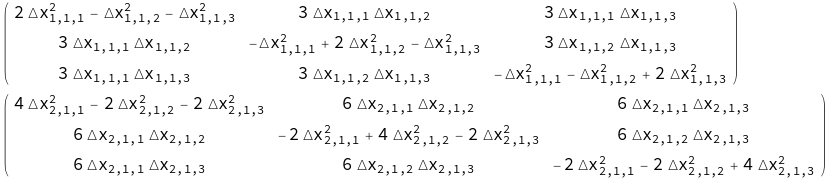
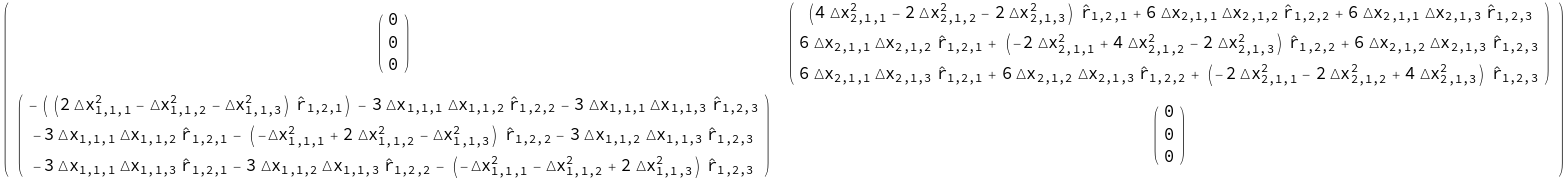
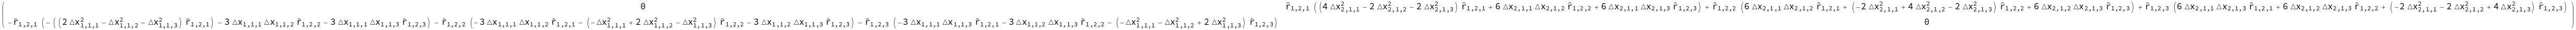
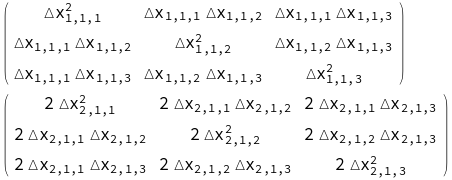

In [450]:
QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm

Q = QijAll[[3]];
Q // MatrixForm

Qsij = QijAll[[4]];
Column[Table[Qsij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qsij]

^                ^                ^
       2 (Δx      r      + Δx      r      + Δx      r     )
 -2         1,1,1  1,2,1     1,1,2  1,2,2     1,1,3  1,2,3
---- + ---------------------------------------------------- + 
r                                 2
 1,2                          r
                               1,2
 
               2          2          2            2          2          2
>   (-2 Δx       + Δx       + Δx       - 2 Δx       + Δx       + Δx       - 
          1,1,1      1,1,2      1,1,3        2,1,1      2,1,2      2,1,3
 
                                             ^      ^
>      6 (Δx      Δx      + Δx      Δx     ) r      r      + 
            1,1,1   1,1,2     2,1,1   2,1,2   1,2,1  1,2,2
 
                 2          2          2          2  ^     2
>      3 (Δx       - Δx       + Δx       - Δx      ) r       - 
            1,1,1      1,1,2      2,1,1      2,1,2    1,2,2
 
                                             ^      ^
>      6 (Δx      Δx      + Δx      Δx     ) r      r      - 
            1,1,1   1,1,3     2,1,1   2,1,3   1,2,1  1,2,3
 
                                             ^      ^
>      6 (Δx      Δx      + Δx      Δx     ) r      r      + 
            1,1,2   1,1,3     2,1,2   2,1,3   1,2,2  1,2,3
 
                 2          2          2          2  ^     2        3
>      3 (Δx       - Δx       + Δx       - Δx      ) r      ) / r     + 
            1,1,1      1,1,3      2,1,1      2,1,3    1,2,3      1,2
 
               3
>   ((2 Δx       - 6 Δx      (Δx      Δx      + Δx      Δx     ) - 
          1,1,1        2,1,1    1,1,2   2,1,2     1,1,3   2,1,3
 
                            2          2            2          2          2   ^
>         3 Δx      (Δx       + Δx       - 2 Δx       + Δx       + Δx      )) r      + 
              1,1,1    1,1,2      1,1,3        2,1,1      2,1,2      2,1,3     1,2,1
 
                   2                  3
>      3 (4 Δx       Δx      - Δx       + 8 Δx      Δx      Δx      - 
              1,1,1    1,1,2     1,1,2        1,1,1   2,1,1   2,1,2
 
>         2 Δx      Δx      Δx      - 
              1,1,3   2,1,2   2,1,3
 
                          2            2            2          2   ^
>         Δx      (Δx       - 4 Δx       + 3 Δx       + Δx      )) r      - 
            1,1,2    1,1,3        2,1,1        2,1,2      2,1,3     1,2,2
 
                 3
>      5 (Δx       - 6 Δx      Δx      Δx      - 
            1,1,1        1,1,2   2,1,1   2,1,2
 
                            2          2          2   ^      ^     2
>         3 Δx      (Δx       - Δx       + Δx      )) r      r       - 
              1,1,1    1,1,2      2,1,1      2,1,2     1,2,1  1,2,2
 
                   2
>      5 (3 Δx       Δx      + 6 Δx      Δx      Δx      - 
              1,1,1    1,1,2       1,1,1   2,1,1   2,1,2
 
                          2            2            2   ^     3
>         Δx      (Δx       - 3 Δx       + 3 Δx      )) r       + 
            1,1,2    1,1,2        2,1,1        2,1,2     1,2,2
 
                               2          2          2            2          2
>      3 (-(Δx      (-4 Δx       + Δx       + Δx       - 4 Δx       + Δx      )) + 
              1,1,3       1,1,1      1,1,2      1,1,3        2,1,1      2,1,2
 
                                                                             2  ^
>         2 (4 Δx      Δx      - Δx      Δx     ) Δx      - 3 Δx      Δx      ) r      + 
                 1,1,1   2,1,1     1,1,2   2,1,2    2,1,3       1,1,3   2,1,3    1,2,3
 
>      30 (Δx      (Δx      Δx      + Δx      Δx     ) + 
             2,1,1    1,1,3   2,1,2     1,1,2   2,1,3
 
                                                       ^      ^      ^
>         Δx      (Δx      Δx      + Δx      Δx     )) r      r      r      - 
            1,1,1    1,1,2   1,1,3     2,1,2   2,1,3    1,2,1  1,2,2  1,2,3
 
                           2          2          2          2
>      15 (Δx      (Δx       - Δx       + Δx       - Δx     
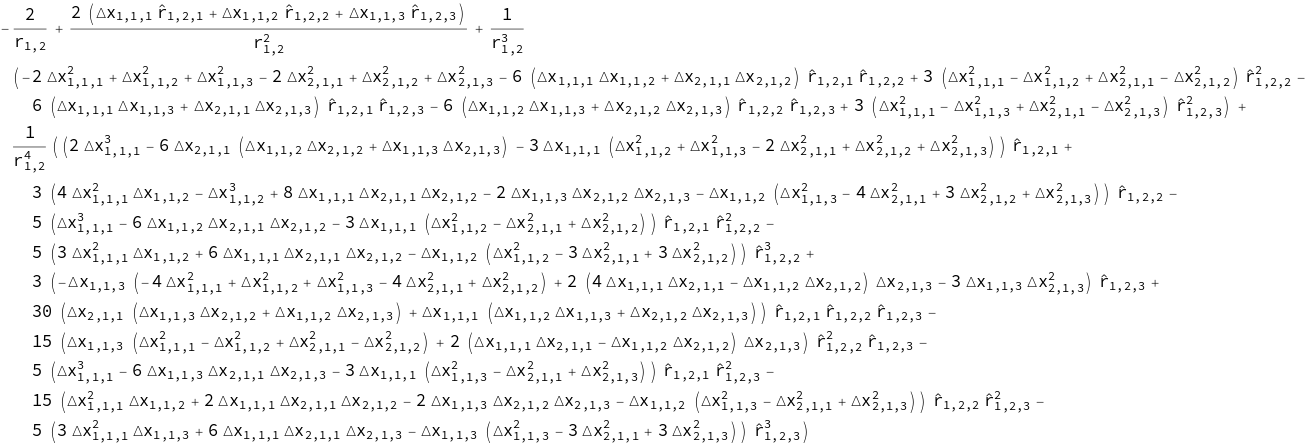

In [487]:
(* Dehnen 2000 eq. 5. *)
(* Marcello 2017 eq. 9  *)

(* Dehnen 1 term *)
(* Marcello 1 line 1 term *)
ClearAll@PhiDehnen1
PhiDehnen1[n_, m_] := Np[[m]]*(-1/rnm[[n, m]])

(* Dehnen 2 term *)
(* Marcello 1 line 3 term *)
ClearAll@PhiDehnen2
PhiDehnen2[n_, m_] := 1/2*EinsteinSummation[{{i, j}, {i, j}}, {Qsij[[m]], DGreen[n, m, 2]}]

(* Dehnen 3 term *)
(* Marcello 2 line 1 term *)
ClearAll@PhiDehnen3
PhiDehnen3[n_, m_] := Np[[m]]*EinsteinSummation[{{i}, {i}}, {dx[[n, 1]], DGreen[n, m, 1]}]

(* Dehnen 4 term, NB: absence of coefficient 1/2 *)
(* Marcello 2 line 3 term *)
ClearAll@PhiDehnen4
PhiDehnen4[n_, m_] := 1/2*EinsteinSummation[{{i}, {j, k}, {i, j, k}}, {dx[[n, 1]], Qsij[[m]], DGreen[n, m, 3]}]

(* Dehnen 5 term *)
(* Marcello 3 line 1 term *)
ClearAll@PhiDehnen5
PhiDehnen5[n_, m_] := 1/2*Np[[m]]*EinsteinSummation[{{i}, {j}, {i, j}}, {dx[[n, 1]], dx[[n, 1]], DGreen[n, m, 2]}] // FullSimplify

(* Dehnen 6 term *)
(* Marcello 3 line 3 term *)
ClearAll@PhiDehnen6
PhiDehnen6[n_, m_] := 1/6*Np[[m]]*EinsteinSummation[{{i}, {j}, {k}, {i, j, k}}, {dx[[n, 1]], dx[[n, 1]], dx[[n, 1]], DGreen[n, m, 3]}]

ClearAll@PhiDehnen
PhiDehnen[n_, m_] :=
  PhiDehnen1[n, m] +
  PhiDehnen2[n, m] +
  PhiDehnen3[n, m] +
  PhiDehnen4[n, m] +
  PhiDehnen5[n, m] +
  PhiDehnen6[n, m]

Collect[FullSimplify[PhiDehnen[1, 2]], 1/rnm[[1, 2]]]

2                      2                      2                      2
-(1 / Sqrt[r     + (Δx      - Δx     )  + (Δx      - Δx     )  + (Δx      - Δx     )  + 
            1,2       1,1,1     2,1,1        1,1,2     2,1,2        1,1,3     2,1,3
 
                                     ^                            ^
>        2 r    ((Δx      - Δx     ) r      + (Δx      - Δx     ) r      + 
            1,2     1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                                ^
>           (Δx      - Δx     ) r     )]) - 
               1,1,3     2,1,3   1,2,3
 
                 2                      2                      2
>   1 / Sqrt[r     + (Δx      + Δx     )  + (Δx      + Δx     )  + 
              1,2       1,1,1     2,1,1        1,1,2     2,1,2
 
                          2
>      (Δx      + Δx     )  + 2 r    
          1,1,3     2,1,3        1,2
 
                             ^                            ^
>       ((Δx      + Δx     ) r      + (Δx      + Δx     ) r      + 
            1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                              ^
>         (Δx      + Δx     ) r     )]
             1,1,3     2,1,3   1,2,3
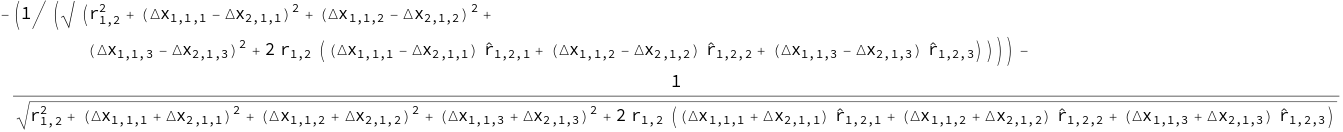

In [530]:
ClearAll@PhiDirect
PhiDirect[n_, m_] := Sum[
  (
    - 1/Sqrt[rnm[[n, m]]^2 + 2*rnm[[n, m]]*(dx[[n, 1]] - dx[[m, p]]).urh[[n, m]] + SquareLength[(dx[[n, 1]] - dx[[m, p]])]]
  )
  , {p, 1, Np[[m]]}
]

PhiDirect[1, 2] // FullSimplify

^                ^                ^
       2 (Δx      r      + Δx      r      + Δx      r     )
 -2         1,1,1  1,2,1     1,1,2  1,2,2     1,1,3  1,2,3
---- + ---------------------------------------------------- - 
r                                 2
 1,2                          r
                               1,2
 
                          ^                            ^
>   (((Δx      - Δx     ) r      + (Δx      - Δx     ) r      + 
         1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                              ^
>         (Δx      - Δx     ) r     ) 
             1,1,3     2,1,3   1,2,3
 
                              2                        2                        2
>       (9 (Δx      - Δx     )  + 9 (Δx      - Δx     )  + 9 (Δx      - Δx     )  - 
              1,1,1     2,1,1          1,1,2     2,1,2          1,1,3     2,1,3
 
                                       ^                            ^
>         15 Power[(Δx      - Δx     ) r      + (Δx      - Δx     ) r      + 
                      1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                                 ^
>            (Δx      - Δx     ) r     , 2]) + 
                1,1,3     2,1,3   1,2,3
 
                            ^                            ^
>      ((Δx      + Δx     ) r      + (Δx      + Δx     ) r      + 
           1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                              ^
>         (Δx      + Δx     ) r     ) 
             1,1,3     2,1,3   1,2,3
 
                              2                        2                        2
>       (9 (Δx      + Δx     )  + 9 (Δx      + Δx     )  + 9 (Δx      + Δx     )  - 
              1,1,1     2,1,1          1,1,2     2,1,2          1,1,3     2,1,3
 
                                       ^                            ^
>         15 Power[(Δx      + Δx     ) r      + (Δx      + Δx     ) r      + 
                      1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                                 ^                     4
>            (Δx      + Δx     ) r     , 2])) / (6 r    ) - 
                1,1,3     2,1,3   1,2,3             1,2
 
                            2                      2                      2
>   (-3 ((Δx      - Δx     )  + (Δx      - Δx     )  + (Δx      - Δx     )  - 
            1,1,1     2,1,1        1,1,2     2,1,2        1,1,3     2,1,3
 
                                      ^                            ^
>         3 Power[(Δx      - Δx     ) r      + (Δx      - Δx     ) r      + 
                     1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                                 ^
>            (Δx      - Δx     ) r     , 2]) - 
                1,1,3     2,1,3   1,2,3
 
                             2                      2                      2
>      3 ((Δx      + Δx     )  + (Δx      + Δx     )  + (Δx      + Δx     )  - 
             1,1,1     2,1,1        1,1,2     2,1,2        1,1,3     2,1,3
 
                                      ^                            ^
>         3 Power[(Δx      + Δx     ) r      + (Δx      + Δx     ) r      + 
                     1,1,1     2,1,1   1,2,1      1,1,2     2,1,2   1,2,2
 
                                 ^                     3
>            (Δx      + Δx     ) r     , 2])) / (6 r    )
                1,1,3     2,1,3   1,2,3             1,2
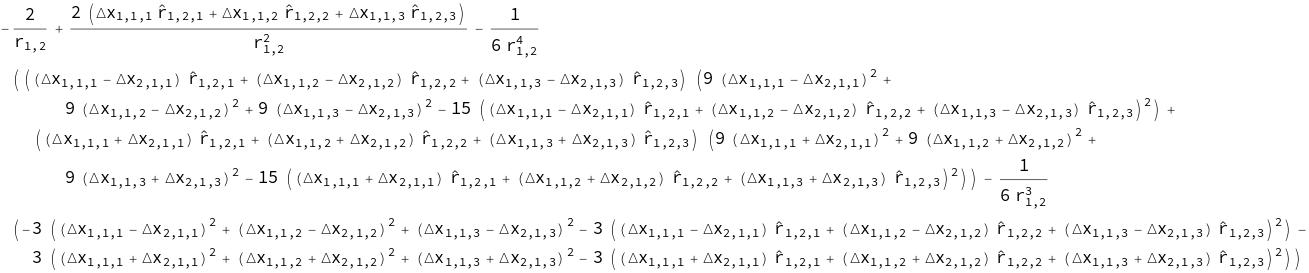

In [534]:
TaylorExpansionRules = MapIndexed[
  # -> t*# &,
  Flatten@Table[dx[[n, 1;;Np[[n]]]], {n, 1, Nn}]
];

ClearAll@PhiDirectSeries
PhiDirectSeries[n_, m_, order_] := Normal@Series[
  Phi[n, m] /. TaylorExpansionRules, {t, 0, order}
] /. t -> 1 // FullSimplify

Collect[PhiDirectSeries[1, 2, 3], 1/rnm[[1, 2]]]

In [535]:
Collect[FullSimplify[PhiDehnen[1, 2] - PhiDirectSeries[1, 2, 3]], 1/rnm[[1, 2]]]

0

^
-2 r
    1,2,1
--------- + 
      2
  r
   1,2
 
       ^               ^                ^                        ^     2     ^     2
     6 r      (Δx      r      + Δx      r     ) + Δx      (4 - 6 r       - 6 r      )
        1,2,1    1,1,2  1,2,2     1,1,3  1,2,3      1,1,1         1,2,2       1,2,3
>    -------------------------------------------------------------------------------- + 
                                              3
                                          r
                                           1,2
 
                2          2            2          2          2  ^
>   (3 ((Δx       + Δx       - 2 Δx       + Δx       + Δx      ) r      - 
           1,1,2      1,1,3        2,1,1      2,1,2      2,1,3    1,2,1
 
                           ^                  2          2          2  ^      ^     2
>        8 Δx      Δx      r      - 5 (Δx       - Δx       + Δx      ) r      r       + 
             2,1,1   2,1,2  1,2,2        1,1,2      2,1,1      2,1,2    1,2,1  1,2,2
 
                            ^     3                     ^
>        10 Δx      Δx      r       - 8 Δx      Δx      r      - 
              2,1,1   2,1,2  1,2,2        2,1,1   2,1,3  1,2,3
 
                                                ^      ^      ^
>        10 (Δx      Δx      + Δx      Δx     ) r      r      r      + 
               1,1,2   1,1,3     2,1,2   2,1,3   1,2,1  1,2,2  1,2,3
 
                            ^     2 ^
>        10 Δx      Δx      r       r      - 
              2,1,1   2,1,3  1,2,2   1,2,3
 
                   2          2          2  ^      ^     2
>        5 (Δx       - Δx       + Δx      ) r      r       + 
              1,1,3      2,1,1      2,1,3    1,2,1  1,2,3
 
                            ^      ^     2                      ^     3
>        10 Δx      Δx      r      r       + 10 Δx      Δx      r       + 
              2,1,1   2,1,2  1,2,2  1,2,3         2,1,1   2,1,3  1,2,3
 
                            ^                ^               ^     2     ^     2
>        2 Δx      (Δx      r      + Δx      r     ) (-4 + 5 r       + 5 r      ) + 
             1,1,1    1,1,2  1,2,2     1,1,3  1,2,3           1,2,2       1,2,3
 
                2 ^              ^     2     ^     2          4
>        Δx       r      (-2 + 5 r       + 5 r      ))) / r
           1,1,1   1,2,1          1,2,2       1,2,3        1,2
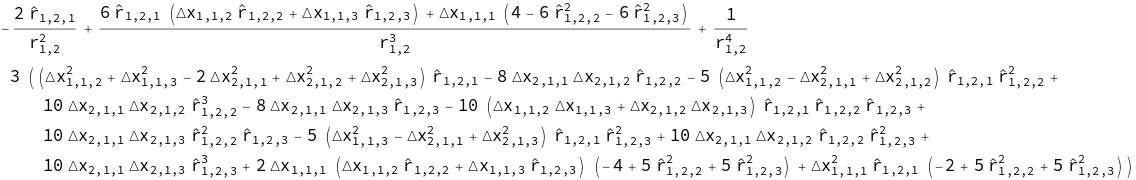

In [538]:
ClearAll@ForceDirect
ForceDirect[n_, m_, i_, order_] := - D[PhiDirectSeries[n, m, order], dx[[n, 1, i]]]

Collect[FullSimplify[ForceDirect[1, 2, 1, 3]], 1/rnm[[1, 2]]]

^
-2 r
    1,2,1
--------- + 
      2
  r
   1,2
 
       ^               ^                ^                        ^     2     ^     2
     6 r      (Δx      r      + Δx      r     ) + Δx      (4 - 6 r       - 6 r      )
        1,2,1    1,1,2  1,2,2     1,1,3  1,2,3      1,1,1         1,2,2       1,2,3
>    -------------------------------------------------------------------------------- + 
                                              3
                                          r
                                           1,2
 
                2          2            2          2          2  ^
>   (3 ((Δx       + Δx       - 2 Δx       + Δx       + Δx      ) r      - 
           1,1,2      1,1,3        2,1,1      2,1,2      2,1,3    1,2,1
 
                           ^                  2          2          2  ^      ^     2
>        8 Δx      Δx      r      - 5 (Δx       - Δx       + Δx      ) r      r       + 
             2,1,1   2,1,2  1,2,2        1,1,2      2,1,1      2,1,2    1,2,1  1,2,2
 
                            ^     3                     ^
>        10 Δx      Δx      r       - 8 Δx      Δx      r      - 
              2,1,1   2,1,2  1,2,2        2,1,1   2,1,3  1,2,3
 
                                                ^      ^      ^
>        10 (Δx      Δx      + Δx      Δx     ) r      r      r      + 
               1,1,2   1,1,3     2,1,2   2,1,3   1,2,1  1,2,2  1,2,3
 
                            ^     2 ^
>        10 Δx      Δx      r       r      - 
              2,1,1   2,1,3  1,2,2   1,2,3
 
                   2          2          2  ^      ^     2
>        5 (Δx       - Δx       + Δx      ) r      r       + 
              1,1,3      2,1,1      2,1,3    1,2,1  1,2,3
 
                            ^      ^     2                      ^     3
>        10 Δx      Δx      r      r       + 10 Δx      Δx      r       + 
              2,1,1   2,1,2  1,2,2  1,2,3         2,1,1   2,1,3  1,2,3
 
                            ^                ^               ^     2     ^     2
>        2 Δx      (Δx      r      + Δx      r     ) (-4 + 5 r       + 5 r      ) + 
             1,1,1    1,1,2  1,2,2     1,1,3  1,2,3           1,2,2       1,2,3
 
                2 ^              ^     2     ^     2          4
>        Δx       r      (-2 + 5 r       + 5 r      ))) / r
           1,1,1   1,2,1          1,2,2       1,2,3        1,2
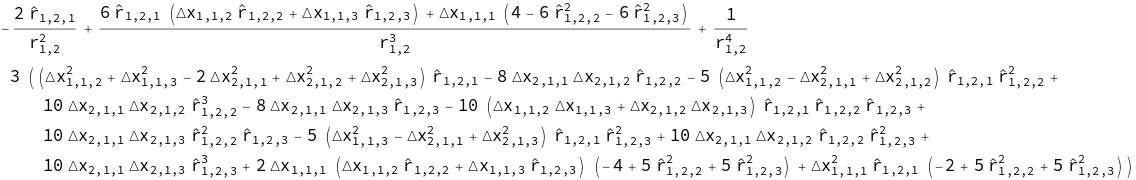

In [523]:
ForcePhantom[n_, m_, i_, order_] := (
  (* 1/r^2 *)
  If[order >= 2, fMPhantom[Np, n, m], 0]
  (* 1/r^4 *)
  + If[order >= 4, fQPhantom[Np, n, m], 0]
  (* 1/r^3 *)
  + If[order >= 3, f2MPhantom[Np, n, m], 0]
  (* 1/r^5 *)
  + If[order >= 5, f2QPhantom[Np, n, m], 0]
  (* 1/r^4 *)
  + If[order >= 4, f3MPhantom[Np, n, m], 0]
  (* 1/r^6 *)
  + If[order >= 6, f3QPhantom[Np, n, m], 0]
)[[i]]

Collect[FullSimplify[ForcePhantom[1, 2, 1, 4]], 1/rnm[[1, 2]]]

In [524]:
Collect[FullSimplify[ForceDirect[1, 2, 1, 3] - ForcePhantom[1, 2, 1, 4]], 1/rnm[[1, 2]]]
Collect[FullSimplify[ForceDirect[1, 2, 2, 3] - ForcePhantom[1, 2, 2, 4]], 1/rnm[[1, 2]]]
Collect[FullSimplify[ForceDirect[1, 2, 3, 3] - ForcePhantom[1, 2, 3, 4]], 1/rnm[[1, 2]]]

0
0
0

In [504]:
FullSimplify[CoefficientList[Force[1, 2, 1, 3] - ForcePhantom[1, 2, 1, 4], 1/rnm[[1, 2]]]]

{0, 0, 0, 0, 0}

2 ^               ^                ^
{0, 0, 0, 0, 0, -15 Δx       r      (Δx      r      + Δx      r     ) 
                      1,1,1   1,2,1    1,1,2  1,2,2     1,1,3  1,2,3
 
              ^     2     ^     2
>     (-4 + 7 r       + 7 r      ) + 
               1,2,2       1,2,3
 
            3         ^     4      ^     2      ^     4      ^     2         ^     2
>    Δx       (8 + 35 r       - 40 r       + 35 r       + 10 r       (-4 + 7 r      )) + 
       1,1,1           1,2,2        1,2,3        1,2,3        1,2,2           1,2,3
 
       ^               ^                ^
>    5 r      (Δx      r      + Δx      r     ) 
        1,2,1    1,1,2  1,2,2     1,1,3  1,2,3
 
              2         ^     2                       ^      ^
>     (Δx       (-3 + 7 r      ) + 14 Δx      Δx      r      r      + 
         1,1,2           1,2,2          1,1,2   1,1,3  1,2,2  1,2,3
 
               2         ^     2
>       Δx       (-3 + 7 r      )) - 
          1,1,3           1,2,3
 
                                   ^      ^              ^     2     ^     2
>    3 Δx      (10 Δx      Δx      r      r      (-6 + 7 r       + 7 r      ) + 
         1,1,1       1,1,2   1,1,3  1,2,2  1,2,3          1,2,2       1,2,3
 
               2        ^     2            ^     2  ^     2      ^     4
>       Δx       (4 - 5 r       + 35 (-1 + r      ) r       + 35 r      ) + 
          1,1,3          1,2,2              1,2,2    1,2,3        1,2,3
 
               2        ^     2      ^     2       ^     2   ^     2
>       Δx       (4 - 5 r       + 35 r       (-1 + r       + r      )))}
          1,1,2          1,2,3        1,2,2         1,2,2     1,2,3
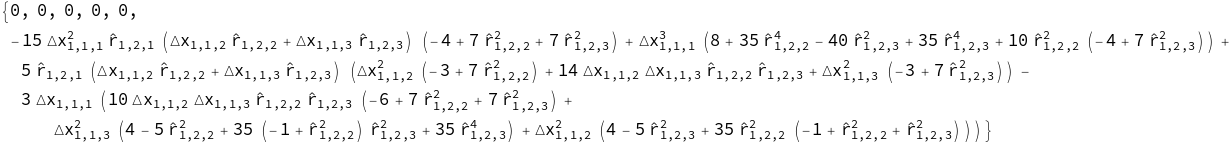

In [527]:
FullSimplify[CoefficientList[ForceDirect[1, 2, 1, 4] - ForcePhantom[1, 2, 1, 5], 1/rnm[[1, 2]]]]